In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score as CVS
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse as RMSE
import scipy.stats as stats
import numbers
import pickle
import folium

## Modelling
Modelling requires several different operations. For ease of repetition, I decided to make functions for these operations, with different options for each which could even be used together.    
The different operations and their functions are:     
 - Transform the Data
  - polynom
  - log
  - minmax_plus
  - norm
  - ohe
 - Feature Selection
  - simple_selector
  - stepwise_selector
  - rfe_selector
 - Handling Multicollinearity
  - multicoll_remove
 - Create the Model
  - model
 - Measuring Results
  - metrics

### polynom
This function creates polynomial columns for the features passed in as to_poly. If poly is 'all' it also creates columns for multiplications between the columns passed in. Lastly, though it gets column names from poly.get_feature_names, these have to be altered to make it readable by statsmodels' ols function.

In [159]:
def polynom(data_t, to_poly, poly='all'):
    poly_order = 2
    if poly == 'all':
        poly=PF(poly_order)
        data_poly = poly.fit_transform(data_t[to_poly])
        data_poly = pd.DataFrame(data_poly)
        data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
        data_t = pd.concat([data_t.drop(to_poly, axis=1),
                            data_poly.drop('1',axis=1)], axis=1)
        data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'), axis=1, inplace=True)
    elif poly == 'singles':
        for feat in to_poly:
            df = pd.DataFrame(data_t[feat])
            print(feat)
            poly=PF(poly_order)
            data_poly = poly.fit_transform(df)
            data_poly = pd.DataFrame(data_poly)
            data_poly.columns = ['drop', feat, feat + '_squared']
            data_t = pd.concat([data_t.drop(feat, axis=1), 
                                data_poly.drop('drop',axis=1)], axis=1)
    return data_t 

### log
log simply replaces the data with the log of the data for the columns passed in as to_log

In [4]:
def log(data_t, to_log):
    for feat in to_log:
        data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)
        #Note 'if' included so that 0 values wouldn't error, will still error
        #...between 0 and 1. Also, implies that the original 0 value was a 1
        #...but as these are around values of 100s, 1000s, the effect is minimal
    return data_t 


### norm
For each column in to_norm, if this isn't the test data, norm calculates its mean and stdev, using them to normalise the column's values. It then records the statistics used for each column so they can be used later for the test data.   
If this is test data (test=True) it reads the stats from the record made previously

In [5]:
def norm(data_t, to_norm, test=False):
    stats = {}
    if test:
        with open('norm_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_norm:
        ft = data_t[feat]
        if test:
            mean = stats[feat][0]
            stdev = stats[feat][1]
        else:
            mean = np.mean(ft)
            stdev = np.sqrt(np.var(ft))
        data_t[feat] = (ft-mean) / stdev
        stats[feat] = [mean, stdev]
    with open('norm_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
    return data_t 


### minmax_plus
This function performs min-max scaling on the columns in to_minmax, and also  multiplies by 100, and adds 1 to,each value to make them log-able. It records the stats used for the train-data and reads it for test-data, in the same way as norm.

In [6]:
def minmax_plus(data_t, to_minmax, test=False):
    stats = {}
    if test:
        with open('minmax_stats.pickle', 'rb') as f:
            stats = pickle.load(f)
    for feat in to_minmax:
        ft = data_t[feat]
        if test:
            min_ = stats[feat][0]
            max_ = stats[feat][1]
        else:
            min_ = ft.min()
            max_ = ft.max()
        data_t[feat] = 1 + 100*(ft-min_)/(max_-min_)
        stats[feat] = [min_, max_]
    with open('minmax_stats.pickle', 'wb') as f:
        pickle.dump(stats, f)
    return data_t 


### ohe
ohe gets dummies for the columns in to_ohe, drops the original, and adds these columns to the dataframe. Lastly, the column names have to be altered to make it readable by statsmodels' ols function.

In [7]:
def ohe(data_t, to_ohe):
    for feat in to_ohe:
        dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
                                drop_first=True)
        data_t.drop(feat, axis=1, inplace=True)
        data_t = pd.concat([data_t, dummies], axis=1)
    data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
                  .replace('^','_pow_'),
                  axis=1, inplace=True)
    return data_t 


### bin_latlong
Calculates (or looks up if it's test data) 5 equal divisions in each of lat and long. Then, for each row, it uses floor division by the bin size to calculate which bin the lat-long belongs in. The bin number increases by latitude first and then by longitude.

In [87]:
def bin_latlong(data_t, test=False):
    
    if not test:
        max_lat = data_t['lat'].max()
        min_lat = data_t['lat'].min()
        x=(max_lat - min_lat)/5

        max_long = data_t['long'].max()
        min_long = data_t['long'].min()
        y=(max_long - min_long)/5
        latlong_vals = [x, min_lat, y, min_long]
        
        with open('latlong_vals.pickle', 'wb') as f:
            pickle.dump(latlong_vals, f)
    else:
        with open('latlong_vals.pickle', 'rb') as f:
            latlong_vals = pickle.load(f)
        x = latlong_vals[0]
        min_lat = latlong_vals[1]
        y = latlong_vals[2]
        min_long = latlong_vals[3]
    
    data_t.loc[:,'lat_long'] = data_t.apply(lambda row: (row.lat-min_lat)//x
                                      + 5*(row.long-min_long)//y, axis=1)
    
    
    
    return data_t

In [329]:
def bin_basement(data_t):
    data_t.sqft_basement = data_t.sqft_basement.apply(lambda x: 
                                                      1 if not x else 0)
    return data_t

### simple_selector
simple_selector starts by calling the model function, returning a model using all the features in x_cols. Only the features in x_cols with a pvalue lower than or equal to alpha are kept and returned.

In [135]:
def simple_selector(data_s, x_cols, alpha=0.1):
    
    results = model(data_s, x_cols)
    pv = pd.DataFrame(results.pvalues).drop('Intercept')
    pv.rename(columns={0:'p_value'}, inplace=True)
    x_cols = list(pv[pv.p_value <= alpha].index)
    
    return x_cols

### stepwise_selector
In this function loops adding or removing features depending on their pvalue each iteration; breaking out of the loop when stable.

In [10]:
def stepwise_selector(data_s, 
                       x_cols=[], 
                       alpha=0.05, 
                       verbose=False):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        x_cols - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    
    X = data_s[x_cols]
    y = data_s['price']
    threshold_in = alpha - 0.02
    threshold_out = alpha + 0.02
    included = list(x_cols)
    while True:
        print(len(included))
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            results = sm.OLS(y, sm.add_constant
                             (pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = results.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        results = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = results.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, 
                                                             worst_pval))
        if not changed:
            break
            
    return included

### rfe_selector
Here features are selected using sklearn's recursive-feature-elimination function for a range of numbers-of-features. Models are created for each set of features and the adjusted r-squared is plotted against the number of features. Using this graph, and the list of results, you can choose how many features you want to select. Enter this number when asked and it will call this function again. But this time specifying the number of features to select and returning with the selected features.     
Note: tried using mpld3 to show y-values when hovering over markers but couldn't get the graph to appear before asking for input.

In [11]:
def rfe_selector(data_s, x_cols, nfts=None):
    X = data_s[x_cols]
    y = data_s[outcome]
    linreg = LR()
    r2_adj = []
    
    n = nfts or 1
    n_max = min(len(x_cols), 80)
    r = range(n, n_max+1)
    while n <= n_max:
   
        selector = RFE(linreg, n_features_to_select=n)
        results = selector.fit(X, y)

        new_cols = []
        for i in range(len(x_cols)):
            if results.support_[i]:
                new_cols.append(x_cols[i])
        
        results = model(data_s, new_cols)
        r2_adj.append(results.rsquared_adj)
        if nfts:
            return new_cols
        n+=1
    print(list(zip(r, r2_adj)))
    fig, ax = plt.subplots()
    lines = ax.plot(r, r2_adj, marker='o')
    plt.show(block=False)
    
    
    print('Select number of features')
    choice = int(input())
    new_cols = rfe_selector(data_s, x_cols, nfts=choice)
    
    return new_cols

### Multicoll_remove    
This function removes a feature from each pair with high multicollinearity    
This function takes in the data, x_cols and the threshold for removing a feature

- create a dataframe of the correlation of the features in x_cols   
- transform this to get a list of pairs of features with high multicollinearity
- for each pair: check whether they are the same feature or if one of the features has already been listed to be removed; if so, continue to next pair 
- otherwise add the feature with the higher p-value to a list    
- remove the features in this list from x_cols    


return x_cols     




In [12]:
def multicoll_remove(data_mr, x_cols, multicollinearity_threshold):
    
    pvalues = model(data_mr, x_cols).pvalues
    corr = data_mr[x_cols].corr().abs().stack().reset_index().sort_values(0,
                                                            ascending = False)
    corr['pairs'] = list(zip(corr.level_0, corr.level_1))
    corr = corr.set_index('pairs').drop(['level_0', 'level_1'], axis=1)
    corr.columns = ['cc']
    corr = corr[corr.cc > multicollinearity_threshold]        

    to_drop = []
    for f0, f1 in corr.index:
        if (f0 == f1) | any(feat in [f0, f1] for feat in to_drop):
            continue
        to_drop.append(pvalues.loc[[f0, f1]]
                       .sort_values(ascending=False).index[0])
    x_cols = list(set(x_cols) - set(to_drop))
    return x_cols   

### metrics
metrics creates two graphs:
- a qqplot
- a residuals plot for homoscedasticity

In [13]:
def metrics(data_m, results, x_cols):
#     X = data[x_cols]
#     y = data.price
#     to_pred = pd.concat([y,X], axis=1)
#     yhat = results.predict(to_pred)
#     rmse = RMSE(y, yhat)
    
#     linreg = LR()
#     linreg.fit(X,y)
#     cv  = np.mean(CVS(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
#     rmse = (-cv)**0.5
      
#     print(f'RMSE: {rmse}')
    print(f'Number of features: {len(x_cols)}')
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45',
                             fit=True, alpha=0.1)

    fig = plt.figure(figsize=(12,12))
    plt.scatter(data_m.price, results.resid, alpha=0.5);
    plt.hlines(0, xmax=data_m.price.max(), xmin=data_m.price.min());    

## model
A small function to create a model using statsmodels' OLS function

In [14]:
def model(data_m, x_cols):
    
    predictors = '+'.join(x_cols)
    f = outcome + '~' + predictors
    results = ols(formula=f, data=data_m).fit()
    return results

### unlog


In [337]:
def unlog(y):
    y = y.map(lambda x: np.e**x)
    return y

# Main

## Load and Split:

In [344]:
data = pd.read_csv('data/clean.csv')
df = pd.read_csv('data/distances.csv')
data = pd.concat([data, df],axis=1)


data = data[data.price < 1000000]
data.sort_index(axis=1, inplace=True)
data_train, data_test = tts(data, train_size=0.8, random_state=111)
data_train = data_train.reset_index().drop('index', axis=1)
data_test = data_test.reset_index().drop('index', axis=1)



##  Modelling

Initial model using only cleaned data:

Number of features: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1646.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:20:06   Log-Likelihood:            -2.0307e+05
No. Observations:               15824   AIC:                         4.062e+05
Df Residuals:                   15788   BIC:                         4.065e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.188e+08   4.87e+06    -24.395      0.000   -1.28e+08   -1.09e+08
Abandoned        -4196.3462    355.082    -11.818      0.000   -4892.347   -3500.346
Access_Point     -6277.9348    281.091    -22.334      0.000   -6828.906   -5726.964
Airport           -189.9623    307.458     -0.618      0.537    -792.614     412.690
Campground        3817.3082    249.161     15.321      0.000    3328.924    4305.692
Cemetery          -461.5775    514.087     -0.898      0.369   -1469.247     546.092
Commercial_Farm  -2934.4112    431.212     -6.805      0.000   -3779.636   -2089.186
Cultural          5698.8022    612.313      9.307      0.000    4498.600    6899.005
Educational       1.731e+04   1076.417     16.083      0.000    1.52e+04    1.94e+04
Fire              1874.7960    667.119      2.810      0.005     567.167    3182.425
Gate_wo_Building -1.086e+04    543.179    -19.995      0.000   -1.19e+04   -9796.314
Gated_w_Building  9515.2652    254.688     37.360      0.000    9016.047       1e+04
Government       -1.025e+04   1057.062     -9.697      0.000   -1.23e+04   -8178.240
Lodging           4729.7424    635.701      7.440      0.000    3483.696    5975.789
Police            4089.6007    266.116     15.368      0.000    3567.983    4611.219
Public_Gathering  2728.9803   1475.827      1.849      0.064    -163.810    5621.771
Seasonal_Home    -4614.6632    361.579    -12.763      0.000   -5323.399   -3905.927
Utility           1918.9166   1609.747      1.192      0.233   -1236.371    5074.204
bathroomsx4       3114.2616    439.409      7.087      0.000    2252.969    3975.554
condition         2.708e+04   1244.673     21.759      0.000    2.46e+04    2.95e+04
date                87.2900      6.417     13.603      0.000      74.712      99.868
floorsx2         -1024.3723   1037.396     -0.987      0.323   -3057.786    1009.042
grade             4.704e+04   1219.454     38.576      0.000    4.47e+04    4.94e+04
lat               2.404e+05   2.13e+04     11.269      0.000    1.99e+05    2.82e+05
long              -8.86e+05   4.08e+04    -21.726      0.000   -9.66e+05   -8.06e+05
sqft_above          43.4207     10.329      4.204      0.000      23.175      63.666
sqft_basement        6.6309     10.221      0.649      0.516     -13.403      26.665
sqft_living         49.8463     10.302      4.839      0.000      29.653      70.039
sqft_living15       48.6938      2.078     23.436      0.000      44.621      52.766
sqft_lot             0.3241      0.038      8.545      0.000       0.250       0.398
sqft_lot15          -0.2403      0.105     -2.297      0.022      -0.445      -0.035
view              2.452e+04   1303.006     18.815      0.000     2.2e+04    2.71e+04
waterfront        1.692e+05   1.51e+04     11.233      0.000     1.4e+05    1.99e+05
yr_built         -1539.

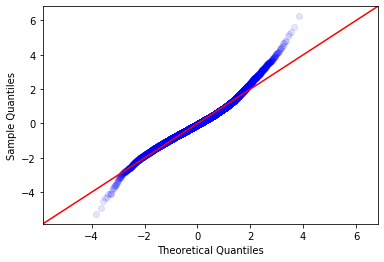

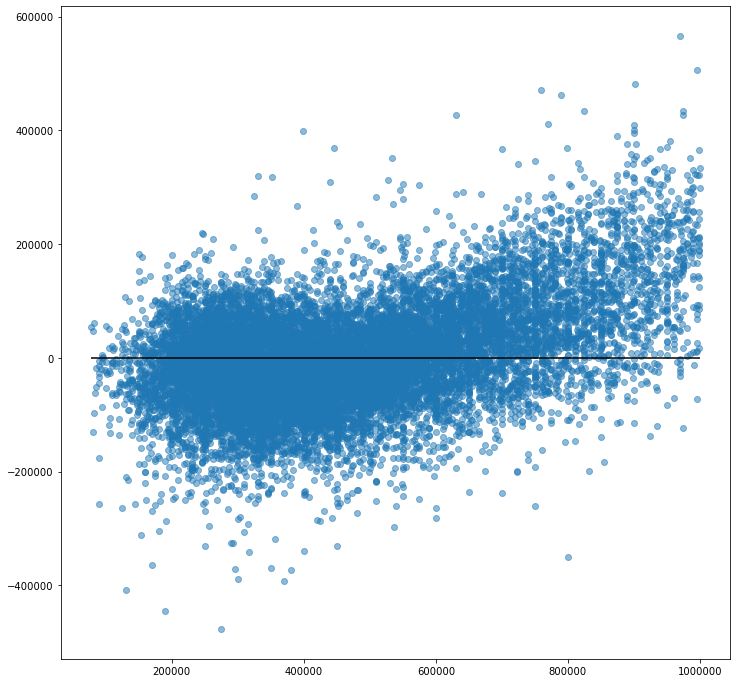

In [59]:
outcome = 'price'
x_cols = data_train.drop([outcome], axis=1).columns

results = model(data_train, x_cols)

metrics(data_train, results, x_cols)
results.summary()

Number of features: 30


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1927.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:30:58   Log-Likelihood:            -2.0305e+05
No. Observations:               15824   AIC:                         4.062e+05
Df Residuals:                   15793   BIC:                         4.064e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.345e+08   5.33e+06    -25.249      0.000   -1.45e+08   -1.24e+08
Abandoned        -4017.0395    330.230    -12.164      0.000   -4664.329   -3369.750
Access_Point     -6419.2941    267.692    -23.980      0.000   -6944.001   -5894.587
Campground        3797.9278    214.197     17.731      0.000    3378.077    4217.778
Commercial_Farm  -2896.9358    425.965     -6.801      0.000   -3731.875   -2061.996
Cultural          5737.8189    603.655      9.505      0.000    4554.587    6921.051
Educational        1.76e+04   1016.425     17.316      0.000    1.56e+04    1.96e+04
Fire              2116.4402    645.291      3.280      0.001     851.596    3381.285
Gate_wo_Building -1.106e+04    518.243    -21.332      0.000   -1.21e+04      -1e+04
Gated_w_Building  9241.6962    197.843     46.712      0.000    8853.901    9629.492
Government       -9659.4157   1005.014     -9.611      0.000   -1.16e+04   -7689.473
Lodging           4706.7937    585.476      8.039      0.000    3559.194    5854.394
Police            3770.7283    244.593     15.416      0.000    3291.298    4250.159
Seasonal_Home    -4535.5135    293.918    -15.431      0.000   -5111.626   -3959.401
bathroomsx4       3397.2596    434.070      7.827      0.000    2546.434    4248.085
bedrooms         -5876.7998   1080.883     -5.437      0.000   -7995.453   -3758.146
condition         2.735e+04   1237.000     22.108      0.000    2.49e+04    2.98e+04
date                87.3611      6.409     13.631      0.000      74.799      99.923
grade             4.635e+04   1223.250     37.894      0.000     4.4e+04    4.88e+04
lat               1.707e+05   2.66e+04      6.413      0.000    1.18e+05    2.23e+05
long             -1.047e+06   5.25e+04    -19.951      0.000   -1.15e+06   -9.44e+05
sqft_above          35.3200      2.225     15.875      0.000      30.959      39.681
sqft_living         61.7863      2.450     25.214      0.000      56.983      66.589
sqft_living15       48.4850      2.058     23.560      0.000      44.451      52.519
sqft_lot             0.3164      0.038      8.353      0.000       0.242       0.391
sqft_lot15          -0.1887      0.102     -1.844      0.065      -0.389       0.012
view               2.42e+04   1296.907     18.658      0.000    2.17e+04    2.67e+04
waterfront        1.699e+05    1.5e+04     11.325      0.000     1.4e+05    1.99e+05
yr_built         -1551.8707     72.454    -21.419      0.000   -1693.889   -1409.853
yr_renovated       757.4816     73.156     10.354      0.000     614.087     900.877
lat_long          7020.2696   1934.932      3.628      0.000    3227.581    1.08e+04
==============================================================================
Omnibus:                     1069.538   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.0

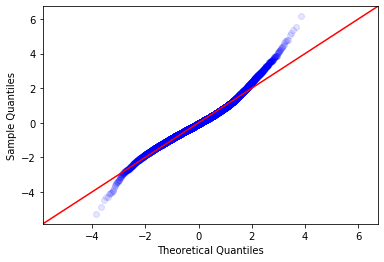

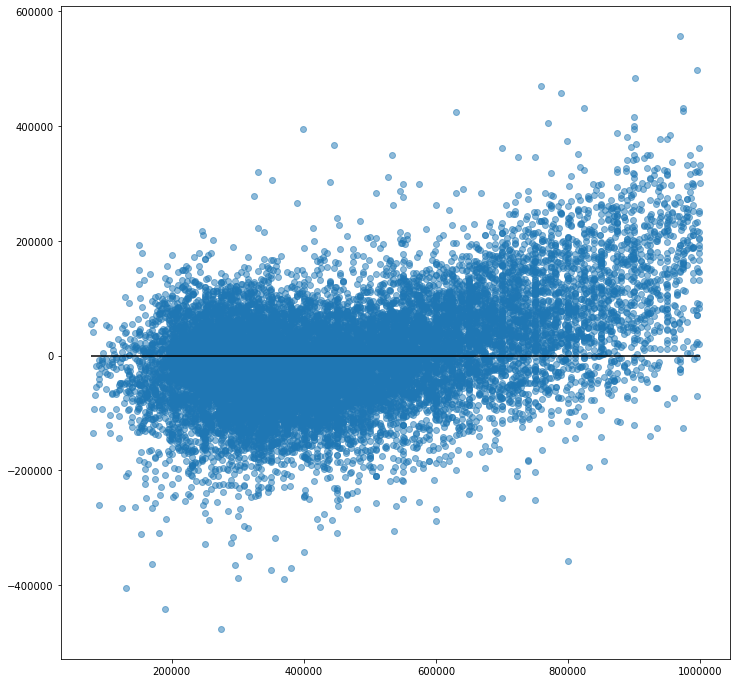

In [262]:
#simple feature selection
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns

x_cols = simple_selector(data_t, x_cols, alpha=alpha)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

Number of features: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     2159.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:31:19   Log-Likelihood:            -2.0398e+05
No. Observations:               15824   AIC:                         4.080e+05
Df Residuals:                   15800   BIC:                         4.082e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.704e+07   5.02e+05    -53.878      0.000    -2.8e+07   -2.61e+07
Police            2524.2879    232.586     10.853      0.000    2068.393    2980.183
sqft_lot             0.2247      0.040      5.608      0.000       0.146       0.303
Government       -5464.3243   1058.127     -5.164      0.000   -7538.374   -3390.275
sqft_living        109.1950      1.782     61.288      0.000     105.703     112.687
Lodging           7577.3409    609.513     12.432      0.000    6382.625    8772.057
Access_Point     -6991.1627    267.437    -26.141      0.000   -7515.370   -6466.955
Gated_w_Building  1.016e+04    203.376     49.959      0.000    9761.766    1.06e+04
lat               5.945e+05   1.01e+04     58.741      0.000    5.75e+05    6.14e+05
condition         2.342e+04   1277.733     18.332      0.000    2.09e+04    2.59e+04
Fire               773.1249    677.150      1.142      0.254    -554.166    2100.416
Campground        2952.7816    223.302     13.223      0.000    2515.084    3390.479
Cultural          8925.9536    629.344     14.183      0.000    7692.368    1.02e+04
date                83.0040      6.790     12.225      0.000      69.696      96.312
Commercial_Farm  -3720.3808    451.033     -8.249      0.000   -4604.458   -2836.304
sqft_lot15           0.0051      0.108      0.047      0.962      -0.206       0.216
view              2.522e+04   1350.403     18.674      0.000    2.26e+04    2.79e+04
Gate_wo_Building -2426.1095    143.193    -16.943      0.000   -2706.784   -2145.435
grade             6.414e+04   1210.085     53.006      0.000    6.18e+04    6.65e+04
Abandoned        -4315.8297    336.571    -12.823      0.000   -4975.546   -3656.113
Educational      -1359.4539    689.642     -1.971      0.049   -2711.230      -7.677
bedrooms         -6321.9969   1122.613     -5.632      0.000   -8522.447   -4121.547
yr_built          -792.2714     36.775    -21.544      0.000    -864.355    -720.188
waterfront        1.895e+05   1.59e+04     11.947      0.000    1.58e+05    2.21e+05
==============================================================================
Omnibus:                     1024.997   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1982.297
Skew:                           0.465   Prob(JB):                         0.00
Kurtosis:                       4.464   Cond. No.                     1.84e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

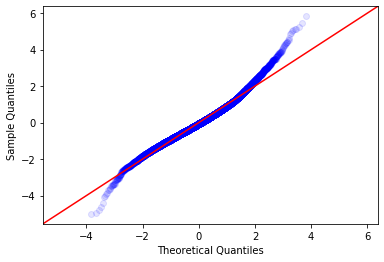

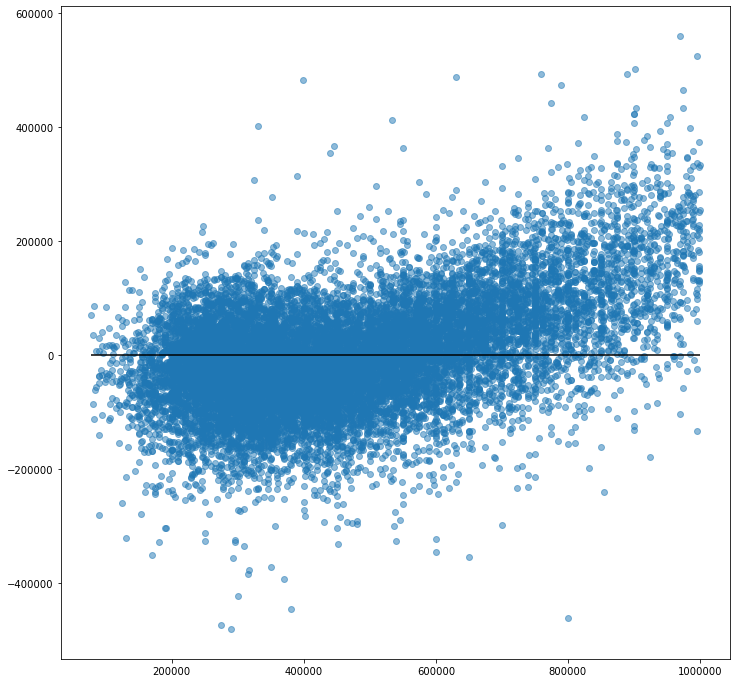

In [263]:
#simple feature selection with multicollinearity removal
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns

x_cols = simple_selector(data_t, x_cols, alpha=alpha)
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

Number of features: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1737.
Date:                Fri, 27 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:20:31   Log-Likelihood:            -2.0432e+05
No. Observations:               15824   AIC:                         4.087e+05
Df Residuals:                   15796   BIC:                         4.089e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -6.625e+06   2.08e+06     -3.192      0.001   -1.07e+07   -2.56e+06
zipcode           -134.3858     20.006     -6.717      0.000    -173.600     -95.171
Police            2072.9949    254.827      8.135      0.000    1573.505    2572.485
sqft_lot             0.3566      0.035     10.062      0.000       0.287       0.426
Government       -7941.6941   1121.999     -7.078      0.000   -1.01e+04   -5742.448
floorsx2          1.076e+04   1080.747      9.959      0.000    8644.769    1.29e+04
Lodging           6502.6743    658.253      9.879      0.000    5212.424    7792.925
Access_Point     -6552.3693    289.251    -22.653      0.000   -7119.334   -5985.405
Gated_w_Building  8368.1084    241.904     34.593      0.000    7893.949    8842.267
lat               6.258e+05   9009.858     69.454      0.000    6.08e+05    6.43e+05
condition         2.545e+04   1328.240     19.158      0.000    2.28e+04    2.81e+04
Fire             -1379.9849    694.914     -1.986      0.047   -2742.097     -17.873
Public_Gathering  5253.4023   1534.768      3.423      0.001    2245.082    8261.723
Campground        2982.9266    261.496     11.407      0.000    2470.364    3495.489
Cultural          6983.8721    645.546     10.819      0.000    5718.529    8249.215
date                86.6125      6.940     12.481      0.000      73.010     100.215
Commercial_Farm  -3719.2109    460.523     -8.076      0.000   -4621.888   -2816.533
sqft_basement       17.4934      2.432      7.194      0.000      12.727      22.260
view              2.254e+04   1408.335     16.003      0.000    1.98e+04    2.53e+04
grade             6.832e+04   1232.499     55.435      0.000    6.59e+04    7.07e+04
bathroomsx4       1.076e+04    434.849     24.746      0.000    9908.577    1.16e+04
Abandoned        -4337.0342    365.041    -11.881      0.000   -5052.556   -3621.512
Educational      -1786.4276    797.634     -2.240      0.025   -3349.881    -222.974
long              6.458e+04   1.02e+04      6.349      0.000    4.46e+04    8.45e+04
sqft_living15       90.8846      1.995     45.549      0.000      86.974      94.796
Airport           2684.3367    303.447      8.846      0.000    2089.546    3279.128
yr_built         -1317.2636     42.336    -31.114      0.000   -1400.247   -1234.280
waterfront         1.91e+05   1.63e+04     11.747      0.000    1.59e+05    2.23e+05
==============================================================================
Omnibus:                     1017.317   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1756.919
Skew:                           0.496   Prob(JB):                         0.00
Kurtosis:                       4.297   Cond. No.                     2.63e+08
=====================================================

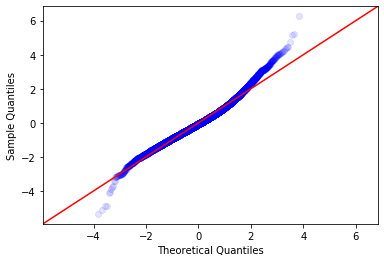

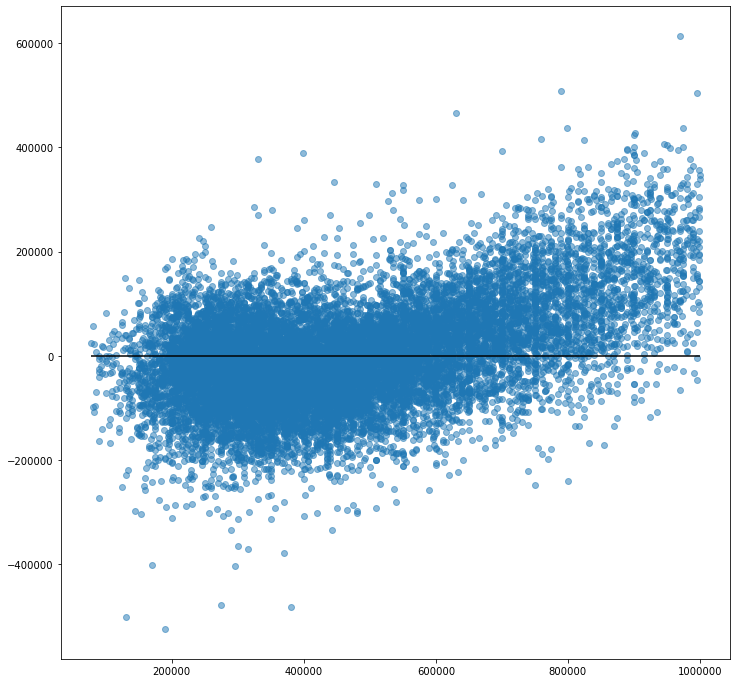

In [60]:
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

## What to Transform?
### One-Hot-Encoding

Candidates for OHE:
 - bedrooms
 - bathroomsx4
 - floorsx2
 - view
 - condition
 - grade
 - lat_long

In [44]:
data.columns

Index(['Abandoned', 'Access_Point', 'Airport', 'Campground', 'Cemetery',
       'Commercial_Farm', 'Cultural', 'Educational', 'Fire',
       'Gate_wo_Building', 'Gated_w_Building', 'Government', 'Lodging',
       'Police', 'Public_Gathering', 'Seasonal_Home', 'Utility', 'bathroomsx4',
       'bedrooms', 'condition', 'date', 'floorsx2', 'grade', 'lat', 'long',
       'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15',
       'sqft_lot', 'sqft_lot15', 'view', 'waterfront', 'yr_built',
       'yr_renovated', 'zipcode'],
      dtype='object')

Number of features: 28


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1686.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:00:46   Log-Likelihood:            -2.0428e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15795   BIC:                         4.088e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7.167e+06   2.07e+06     -3.460      0.001   -1.12e+07   -3.11e+06
zipcode           -131.8522     19.958     -6.606      0.000    -170.973     -92.731
Police            2191.9310    254.540      8.611      0.000    1693.004    2690.858
sqft_lot             0.3611      0.035     10.212      0.000       0.292       0.430
Government       -7922.6148   1119.206     -7.079      0.000   -1.01e+04   -5728.843
floorsx2           1.03e+04   1079.293      9.544      0.000    8185.304    1.24e+04
Lodging           6593.3667    656.691     10.040      0.000    5306.177    7880.557
Access_Point     -6464.7172    288.697    -22.393      0.000   -7030.596   -5898.839
Gated_w_Building  8454.0197    241.492     35.007      0.000    7980.667    8927.372
lat               6.301e+05   9000.393     70.008      0.000    6.12e+05    6.48e+05
condition         2.513e+04   1325.414     18.958      0.000    2.25e+04    2.77e+04
Fire             -1428.4286    693.205     -2.061      0.039   -2787.189     -69.669
Public_Gathering  5339.8054   1530.975      3.488      0.000    2338.919    8340.692
Campground        3168.6897    261.670     12.109      0.000    2655.786    3681.594
Cultural          6895.7193    644.013     10.707      0.000    5633.380    8158.058
date                85.7698      6.923     12.389      0.000      72.200      99.340
Commercial_Farm  -3821.9780    459.519     -8.317      0.000   -4722.688   -2921.268
sqft_basement       13.3155      2.470      5.391      0.000       8.474      18.157
view              2.341e+04   1408.227     16.626      0.000    2.07e+04    2.62e+04
grade             6.812e+04   1229.631     55.402      0.000    6.57e+04    7.05e+04
bathroomsx4       9436.4842    458.346     20.588      0.000    8538.074    1.03e+04
Abandoned        -4508.7842    364.638    -12.365      0.000   -5223.516   -3794.053
Educational      -1583.4235    795.970     -1.989      0.047   -3143.616     -23.231
long              6.489e+04   1.01e+04      6.395      0.000     4.5e+04    8.48e+04
sqft_living15       88.6635      2.006     44.204      0.000      84.732      92.595
bedrooms          9733.6332   1088.292      8.944      0.000    7600.456    1.19e+04
Airport           2678.0814    302.692      8.848      0.000    2084.770    3271.392
yr_built         -1261.7360     42.685    -29.560      0.000   -1345.403   -1178.069
waterfront        1.932e+05   1.62e+04     11.910      0.000    1.61e+05    2.25e+05
==============================================================================
Omnibus:                     1052.101   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1830.450
Skew:                           0.507   Prob(JB):                         0.00
Kurtosis:                       4.322   Cond. N

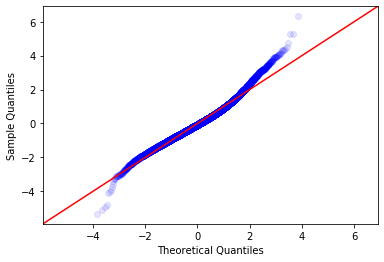

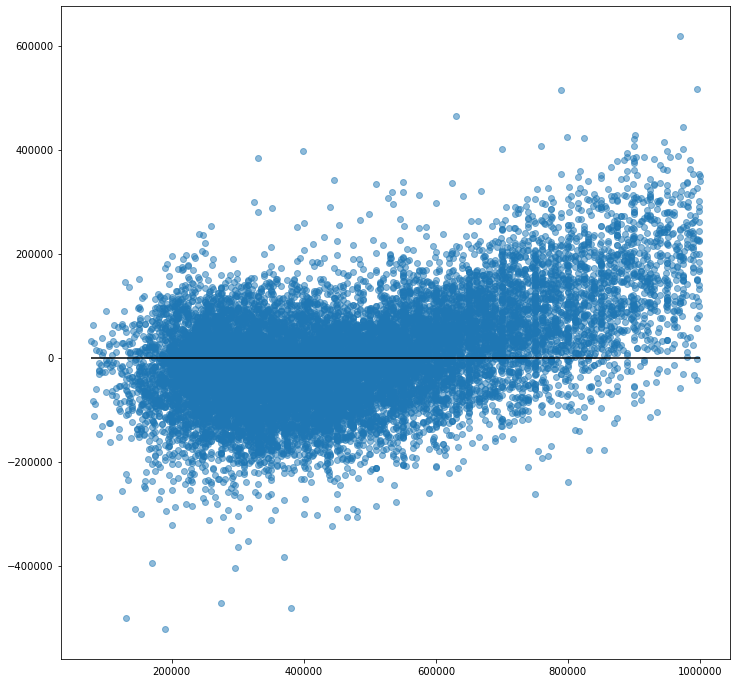

In [123]:
#Base model to compare against
multicollinearity_threshold=0.7
alpha=0.1
outcome = 'price'

data_t = data_train.copy()
x_cols = data_t.drop([outcome], axis=1).columns
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

Number of features: 30
bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1577.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:50:41   Log-Likelihood:            -2.0427e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15793   BIC:                         4.088e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercep

Number of features: 31
view
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1529.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:50:47   Log-Likelihood:            -2.0426e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15792   BIC:                         4.088e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept   

strong multicollinearity or other numerical problems.


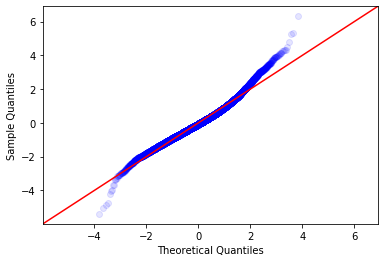

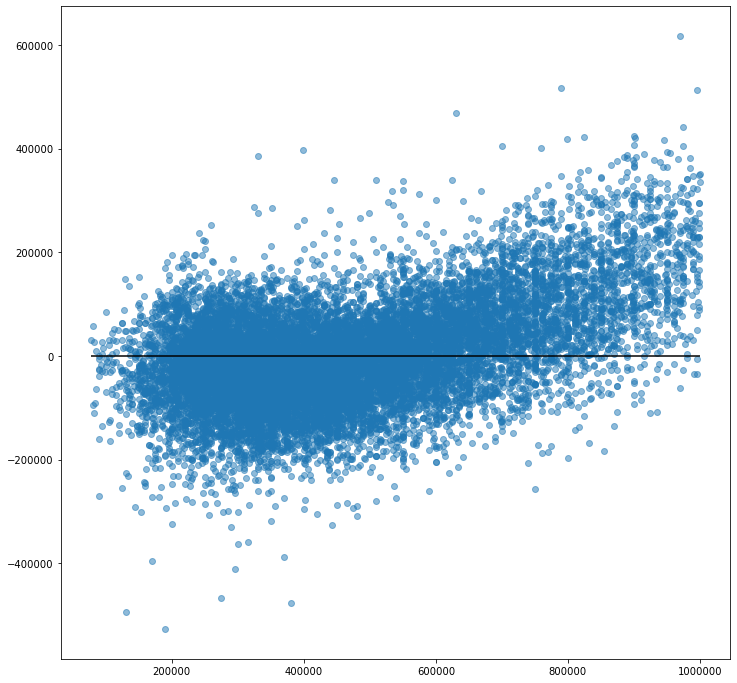

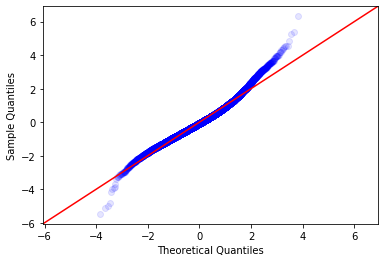

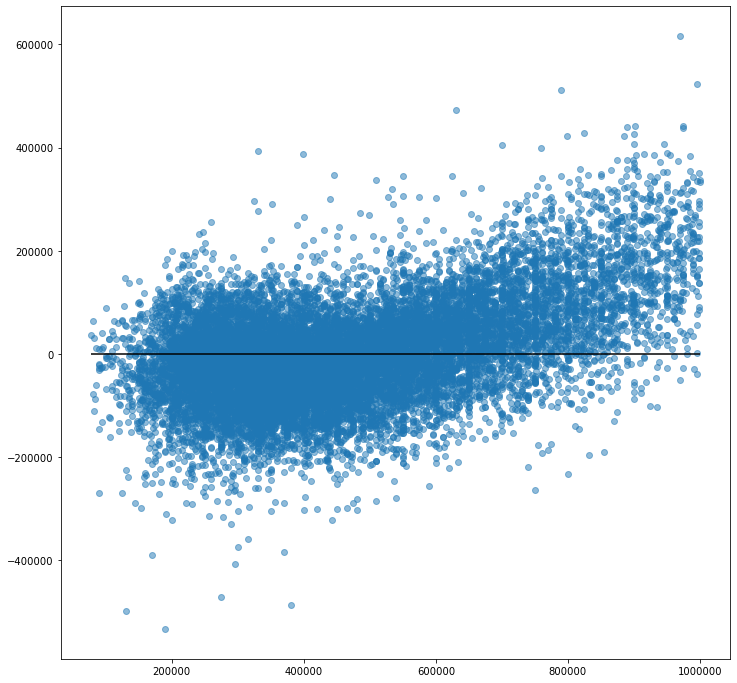

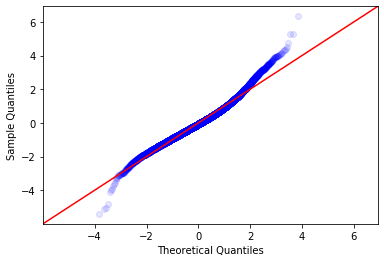

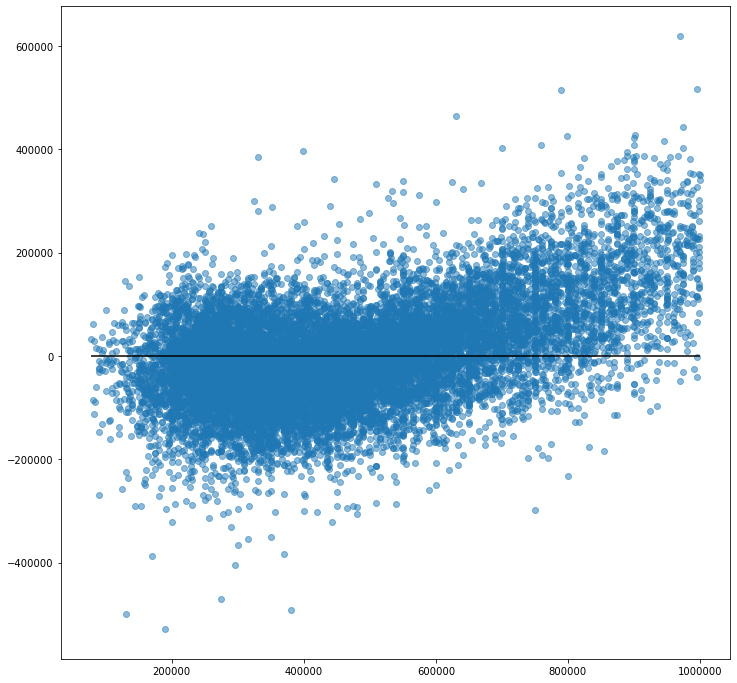

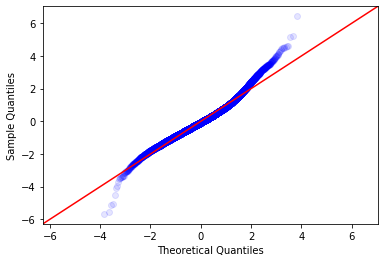

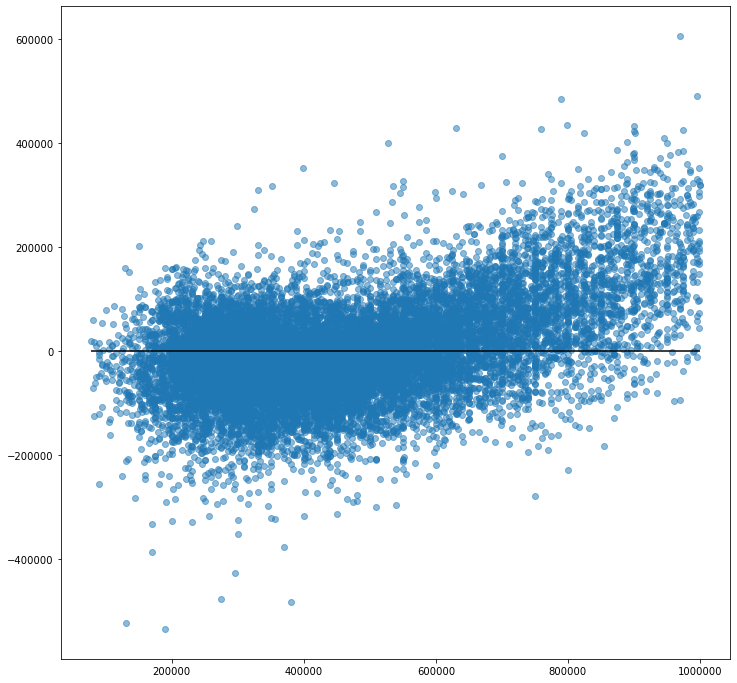

In [121]:
#Run models to ohe each ohe candidate separately:
multicollinearity_threshold=0.7
alpha=0.1
cand_ohe = ['bedrooms', 'bathroomsx4', 'floorsx2', 'view', 'condition', 'grade',
           'lat_long']

for feat in cand_ohe:
    data_t = data_train.copy()
    if feat == 'lat_long':
        data_t = bin_latlong(data_t)
    to_ohe = [feat]
    data_t = ohe(data_t, to_ohe)
    x_cols = data_t.drop([outcome], axis=1).columns
    x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
    x_cols = simple_selector(data_t, x_cols)

    
    results = model(data_t, x_cols)
    if results.rsquared_adj > 0.749:
        metrics(data_t, results, x_cols)
        print(feat)
        print(results.summary())

The only OHE candidate that made any significant improvement was the binned lat_long feature

### Log 

Number of features: 26
Gate_wo_Building
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1853.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:49:54   Log-Likelihood:            -2.0416e+05
No. Observations:               15824   AIC:                         4.084e+05
Df Residuals:                   15797   BIC:                         4.086e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


Number of features: 27
Seasonal_Home
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1783.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:49:56   Log-Likelihood:            -2.0417e+05
No. Observations:               15824   AIC:                         4.084e+05
Df Residuals:                   15796   BIC:                         4.086e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Int

Number of features: 28
price
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1865.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:50:00   Log-Likelihood:                 2284.5
No. Observations:               15824   AIC:                            -4511.
Df Residuals:                   15795   BIC:                            -4289.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept  

Number of features: 29
sqft_lot15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1630.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:50:03   Log-Likelihood:            -2.0427e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15794   BIC:                         4.088e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Interc

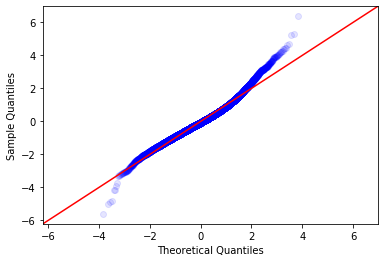

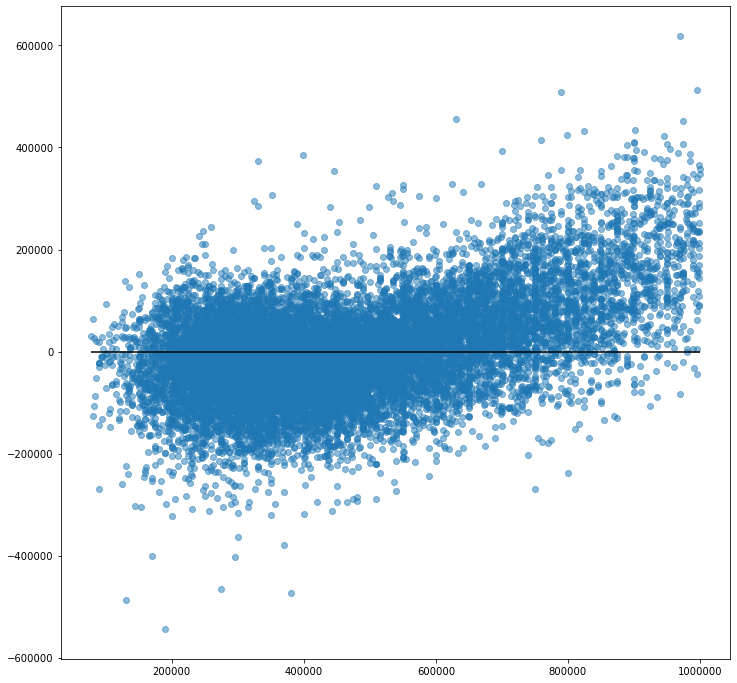

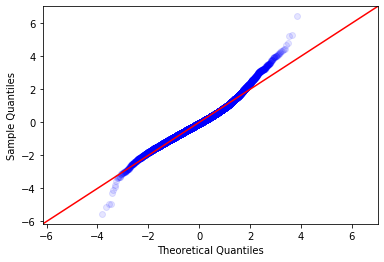

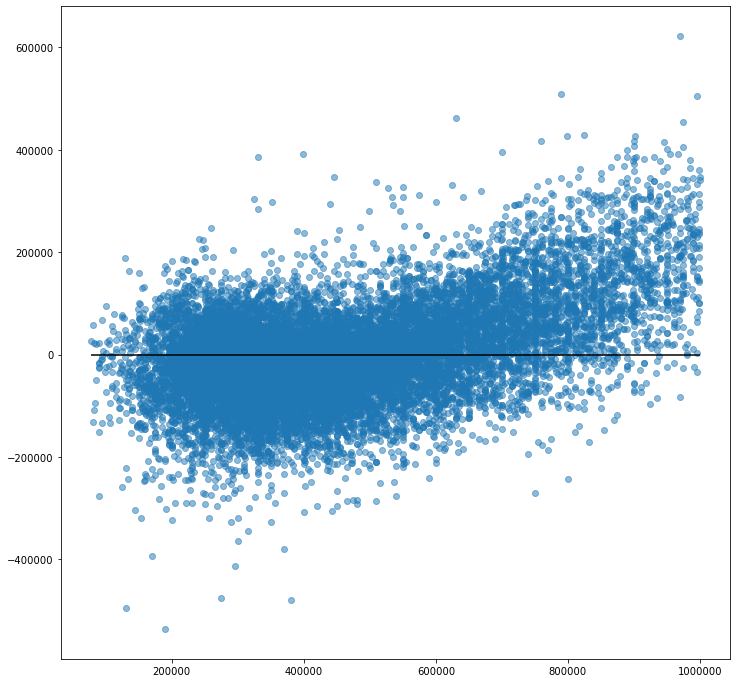

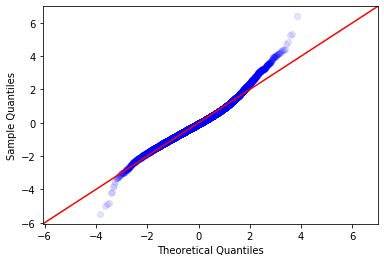

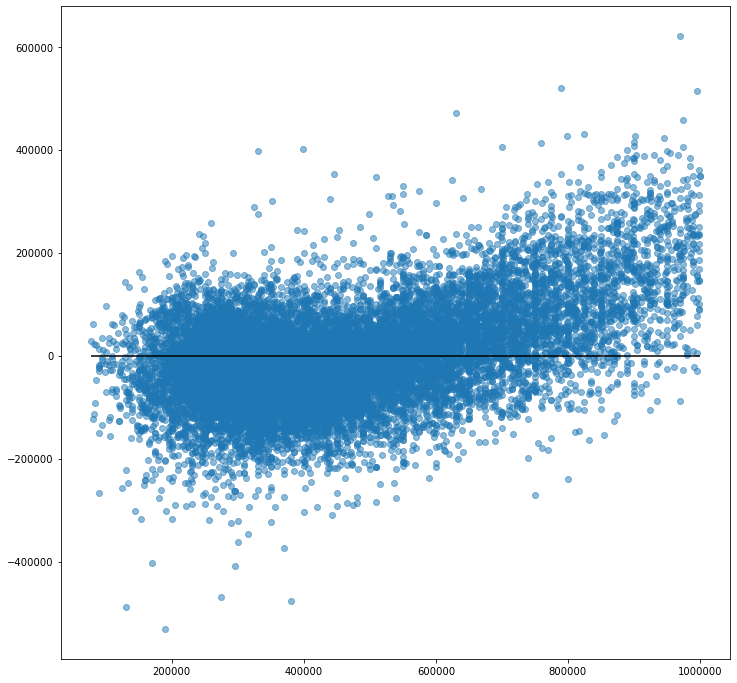

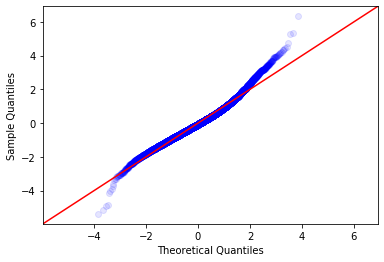

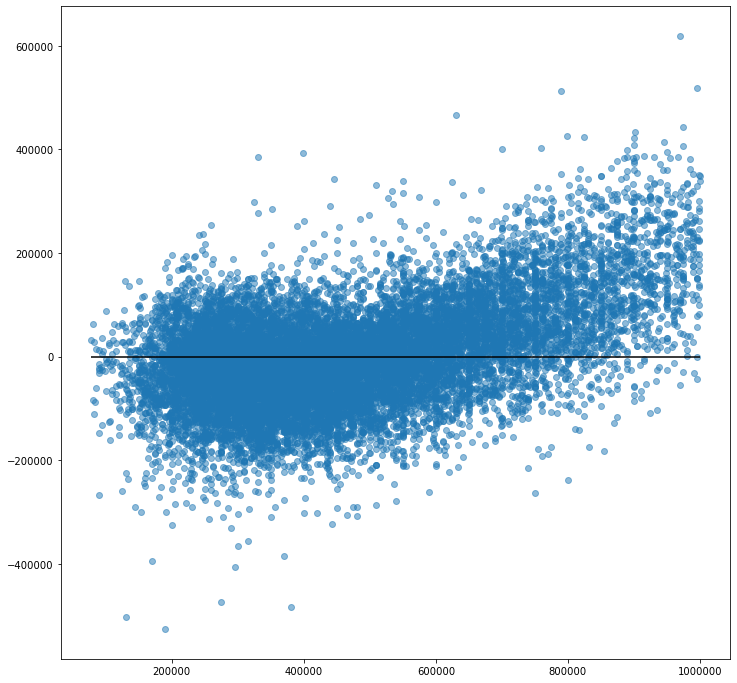

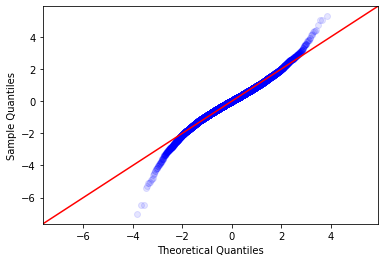

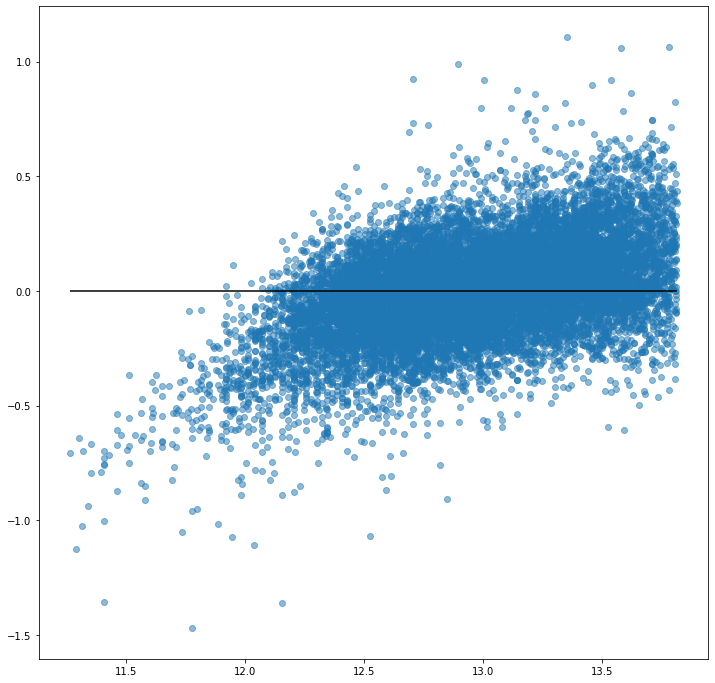

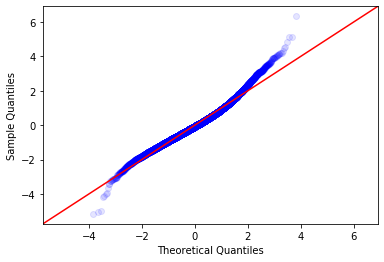

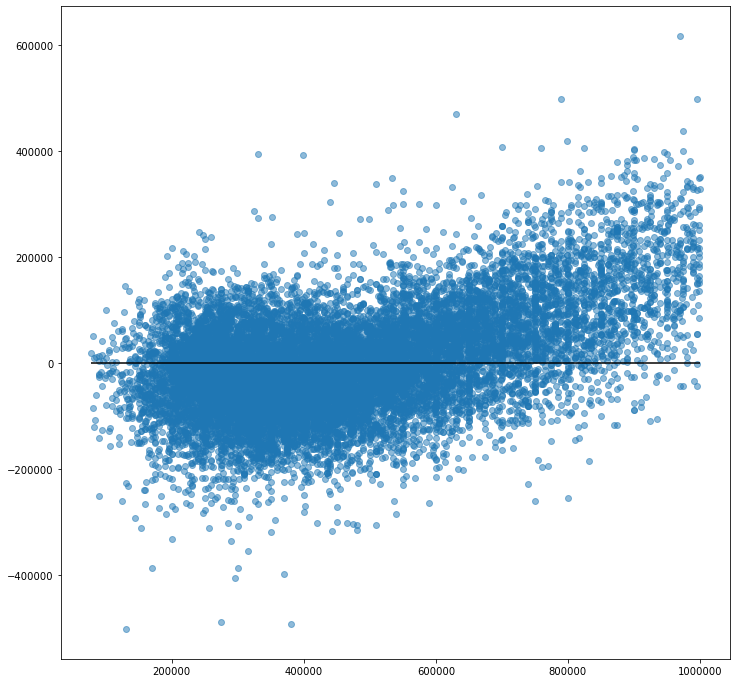

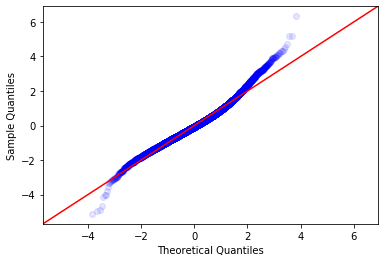

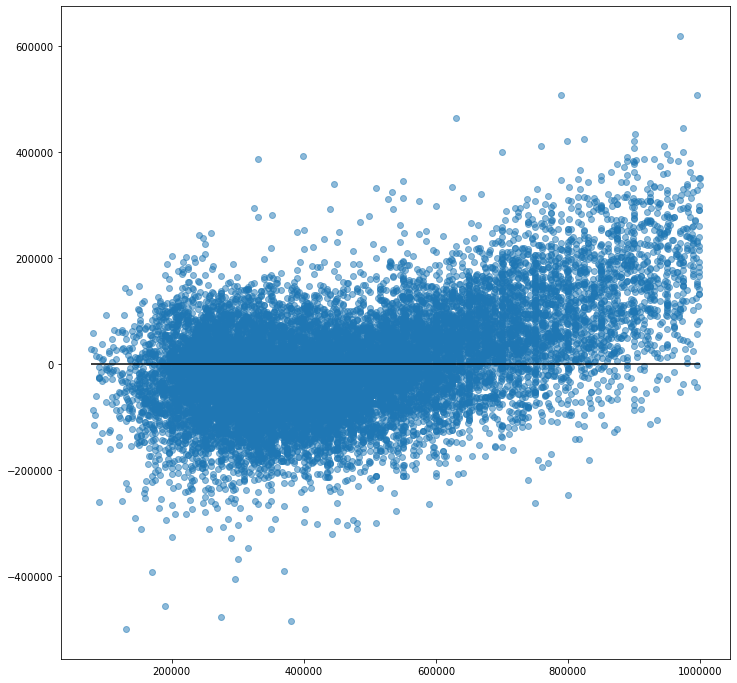

In [119]:
data_t = data_train.copy()
multicollinearity_threshold=0.7
alpha=0.1
cand_log = data_t.drop(['lat', 'long', 'waterfront', 'zipcode'], axis=1).columns

for feat in cand_log:
    data_t = data_train.copy()
    to_log = [feat]
    data_t = log(data_t, to_log)
    x_cols = data_t.drop([outcome], axis=1).columns
    x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
    x_cols = simple_selector(data_t, x_cols)

    
    results = model(data_t, x_cols)
    if results.rsquared_adj > 0.749:
        metrics(data_t, results, x_cols)
        print(feat)
        print(results.summary())

In [109]:
data_t = data_train.copy()
multicollinearity_threshold=0.7
alpha=0.1

cand_log = data_t.drop(['lat', 'long', 'waterfront', 'zipcode'], axis=1).columns
cand_log

Index(['Abandoned', 'Access_Point', 'Airport', 'Campground', 'Cemetery',
       'Commercial_Farm', 'Cultural', 'Educational', 'Fire',
       'Gate_wo_Building', 'Gated_w_Building', 'Government', 'Lodging',
       'Police', 'Public_Gathering', 'Seasonal_Home', 'Utility', 'bathroomsx4',
       'bedrooms', 'condition', 'date', 'floorsx2', 'grade', 'price',
       'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15',
       'sqft_lot', 'sqft_lot15', 'view', 'yr_built', 'yr_renovated'],
      dtype='object')

### Scaled-Log

Number of features: 26
Gate_wo_Building
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1853.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:51:13   Log-Likelihood:            -2.0416e+05
No. Observations:               15824   AIC:                         4.084e+05
Df Residuals:                   15797   BIC:                         4.086e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


Number of features: 26
Public_Gathering
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1817.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:51:16   Log-Likelihood:            -2.0428e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15797   BIC:                         4.088e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


Number of features: 28
floorsx2
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     1696.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:51:19   Log-Likelihood:            -2.0425e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15795   BIC:                         4.088e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercep

Number of features: 27
sqft_living
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     1893.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:51:21   Log-Likelihood:            -2.0381e+05
No. Observations:               15824   AIC:                         4.077e+05
Df Residuals:                   15796   BIC:                         4.079e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Inter

Number of features: 29
sqft_lot15
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1630.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        08:51:22   Log-Likelihood:            -2.0428e+05
No. Observations:               15824   AIC:                         4.086e+05
Df Residuals:                   15794   BIC:                         4.088e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Interc

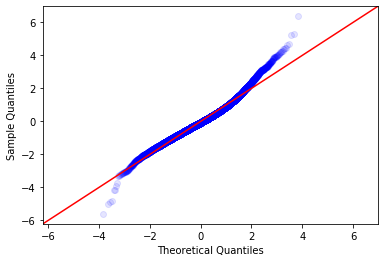

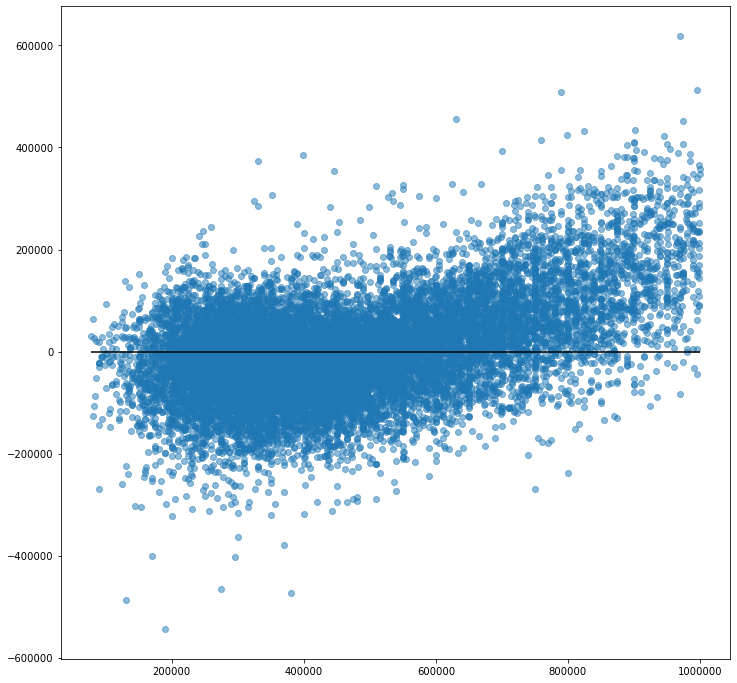

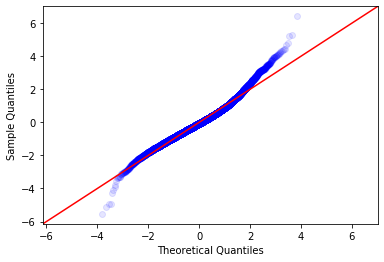

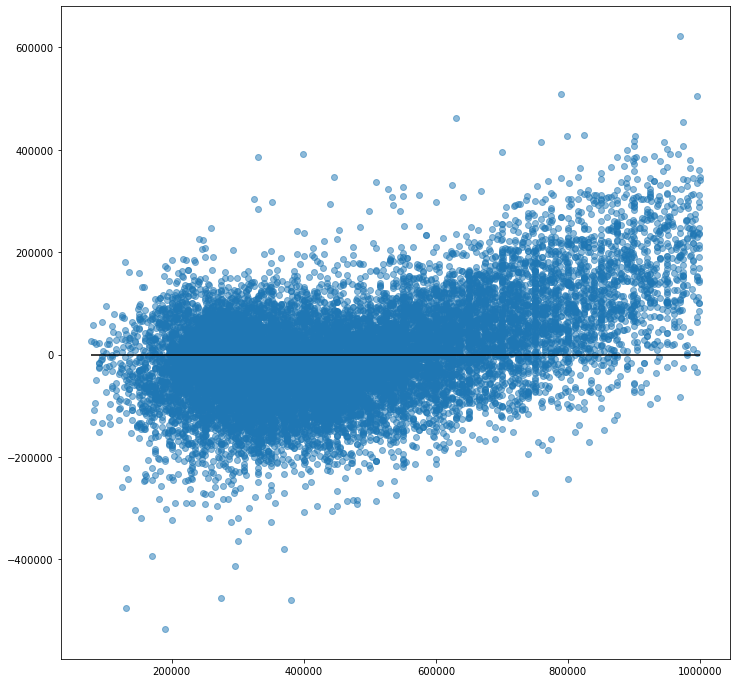

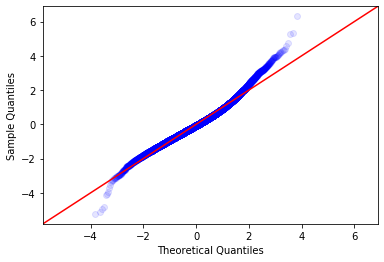

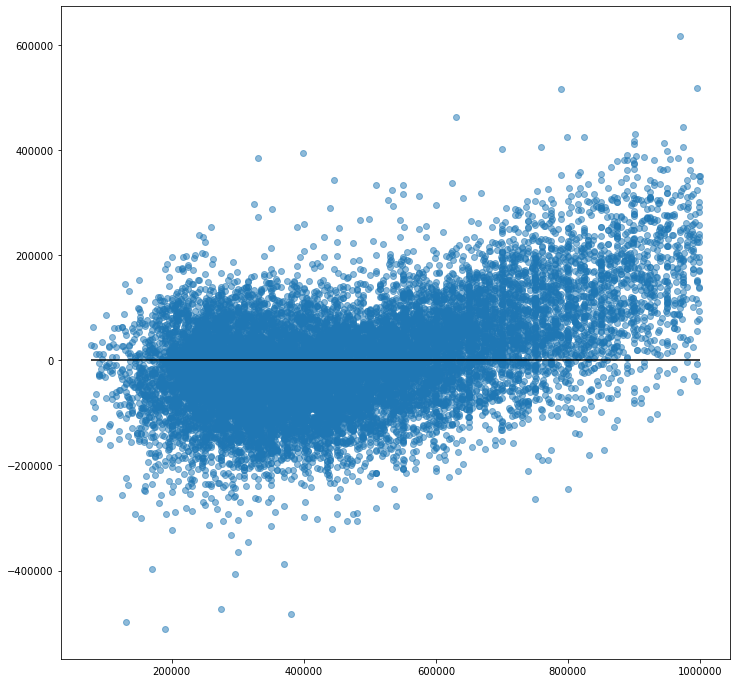

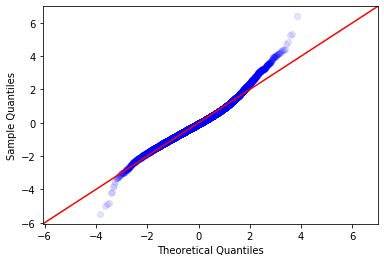

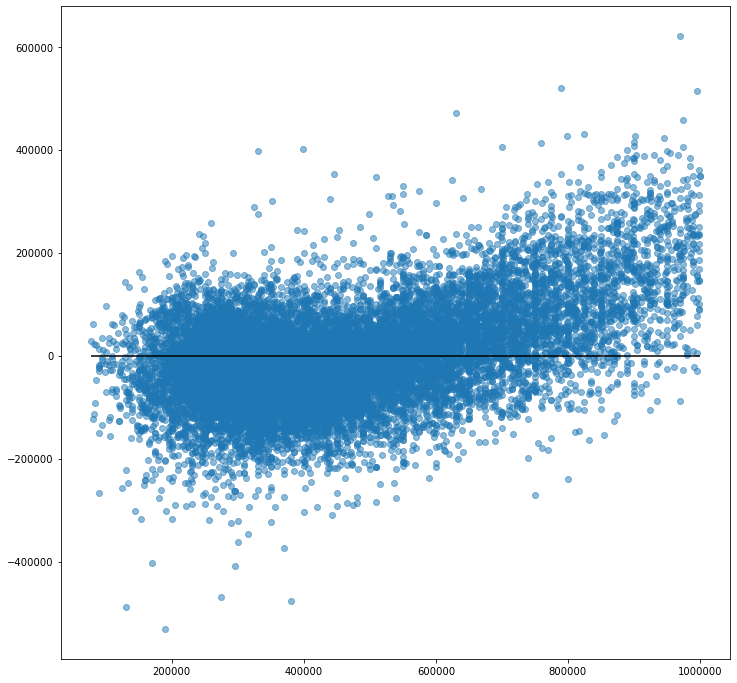

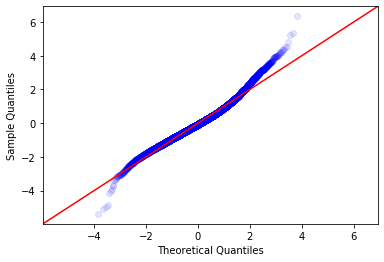

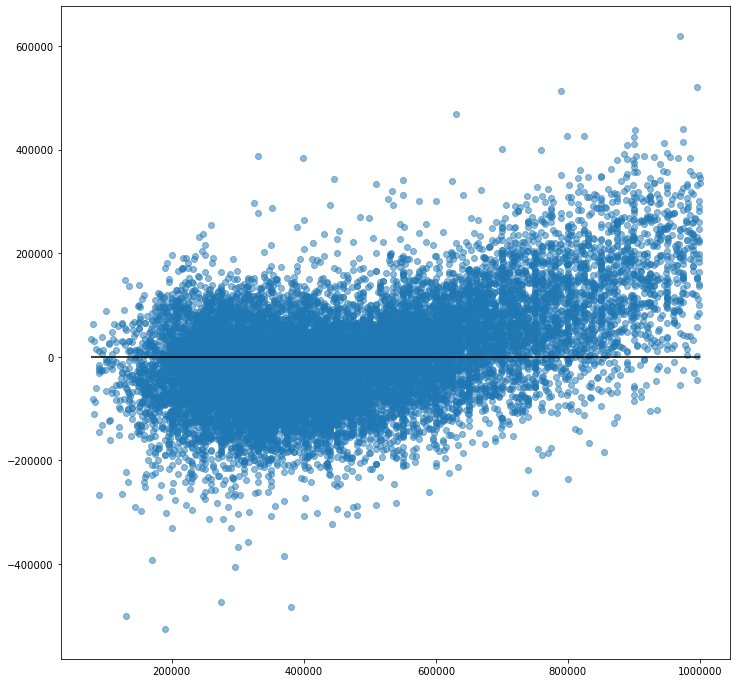

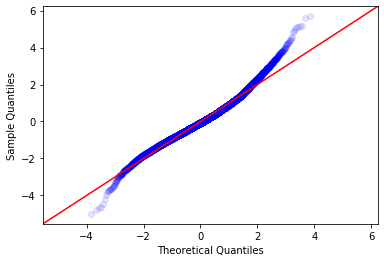

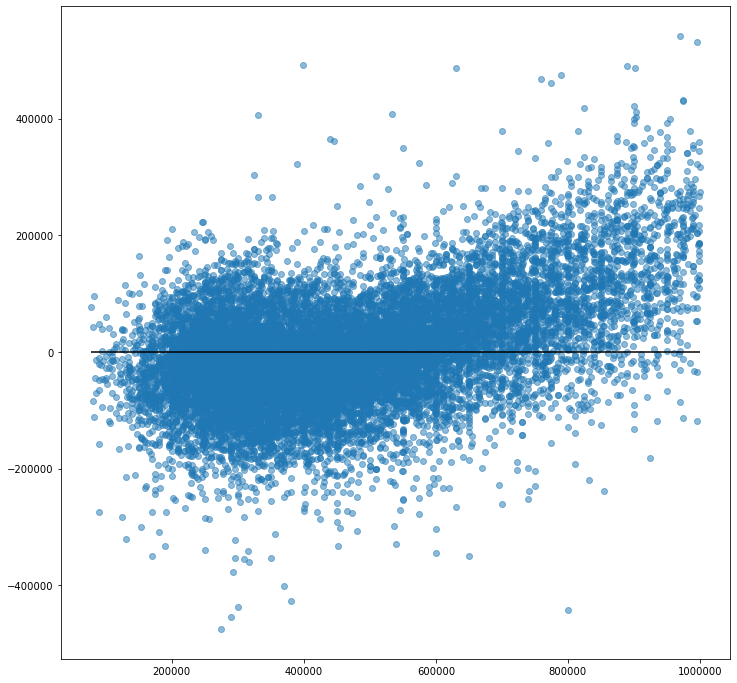

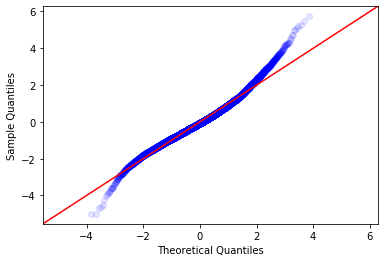

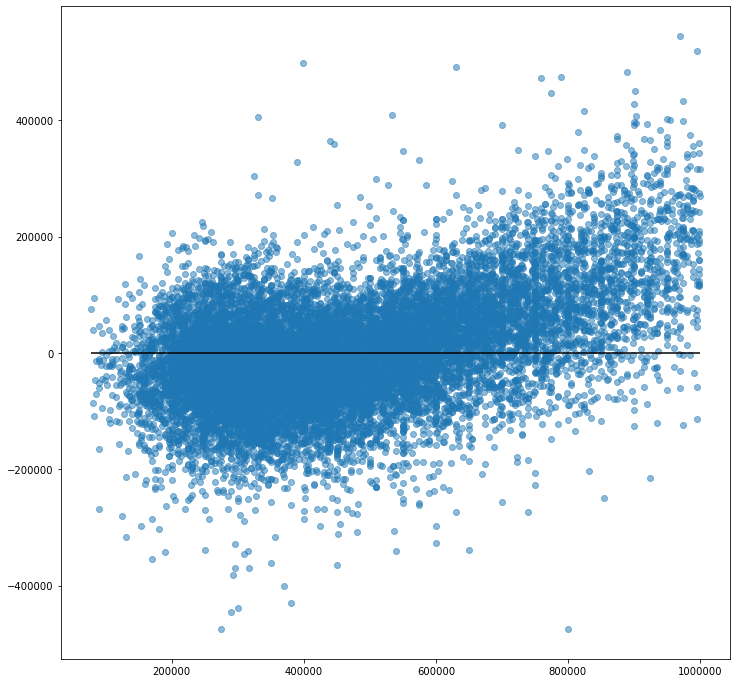

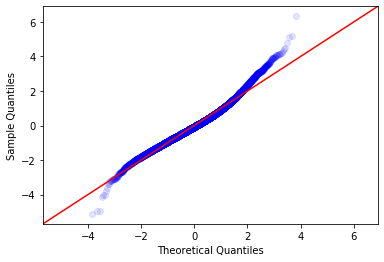

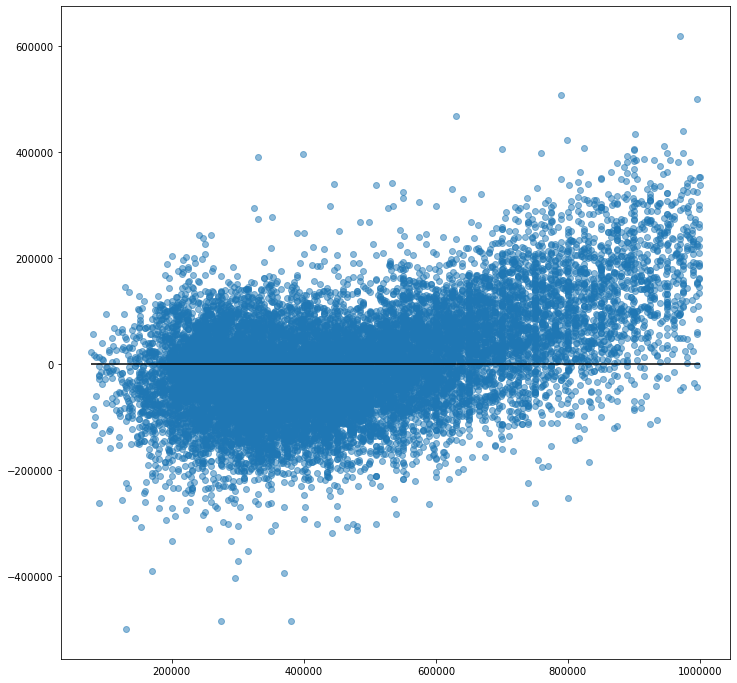

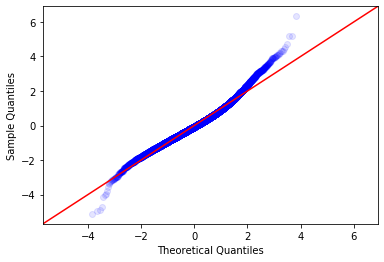

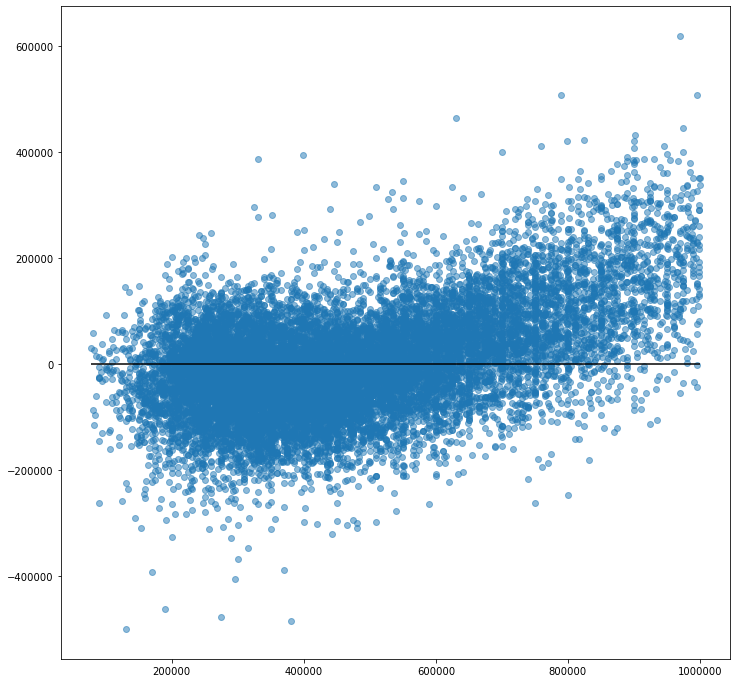

In [122]:
data_t = data_train.copy()
multicollinearity_threshold=0.7
alpha=0.1
cand_log = data_t.drop(['lat', 'long', 'waterfront', 'zipcode'], axis=1).columns

for feat in cand_log:
    data_t = data_train.copy()
    to_log = [feat]
    data_t = minmax_plus(data_t, to_log)
    data_t = log(data_t, to_log)
    x_cols = data_t.drop([outcome], axis=1).columns
    x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
    x_cols = simple_selector(data_t, x_cols)

    
    results = model(data_t, x_cols)
    
    if results.rsquared_adj > 0.749:
        metrics(data_t, results, x_cols)
        print(feat)
        print(results.summary())

Benefitting from being log transformed are:
 - Gate_wo_building
 - Police
 - Seasonal Home
 - price
 - sqft_lot   
 
Benefitting from being scaled and then log transformed are:
 - sqft_above
 - sqft_living

Number of features: 33


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1613.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:41:52   Log-Likelihood:                 2402.8
No. Observations:               15824   AIC:                            -4738.
Df Residuals:                   15790   BIC:                            -4477.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1545      4.385      0.263      0.792      -7.441       9.750
zipcode             -0.0004   4.27e-05     -9.220      0.000      -0.000      -0.000
Police               0.0587      0.003     18.788      0.000       0.053       0.065
sqft_lot             0.0455      0.003     14.942      0.000       0.040       0.052
Government          -0.0177      0.002     -7.285      0.000      -0.022      -0.013
floorsx2             0.0334      0.002     14.060      0.000       0.029       0.038
Lodging              0.0163      0.001     11.799      0.000       0.014       0.019
lat_long_14          0.1460      0.015      9.966      0.000       0.117       0.175
Access_Point        -0.0111      0.001    -18.220      0.000      -0.012      -0.010
lat_long_20         -0.5563      0.211     -2.642      0.008      -0.969      -0.144
Gated_w_Building     0.0215      0.001     40.449      0.000       0.020       0.023
lat                  1.5960      0.019     82.731      0.000       1.558       1.634
lat_long_28         -0.7606      0.084     -9.038      0.000      -0.926      -0.596
condition            0.0600      0.003     21.349      0.000       0.055       0.066
lat_long_27         -0.5710      0.100     -5.716      0.000      -0.767      -0.375
Public_Gathering    -0.0105      0.003     -3.269      0.001      -0.017      -0.004
lat_long_3          -0.2018      0.017    -11.758      0.000      -0.235      -0.168
Campground           0.0097      0.001     16.969      0.000       0.009       0.011
Cultural             0.0182      0.001     13.096      0.000       0.015       0.021
date                 0.0002   1.47e-05     13.847      0.000       0.000       0.000
Commercial_Farm     -0.0052      0.001     -5.318      0.000      -0.007      -0.003
sqft_basement        0.0393      0.004      9.448      0.000       0.031       0.048
view                 0.0444      0.003     14.898      0.000       0.039       0.050
Utility              0.0101      0.004      2.721      0.007       0.003       0.017
grade                0.1350      0.003     51.367      0.000       0.130       0.140
bathroomsx4          0.0227      0.001     23.530      0.000       0.021       0.025
Abandoned           -0.0118      0.001    -14.918      0.000      -0.013      -0.010
long                 0.1996      0.021      9.352      0.000       0.158       0.241
lat_long_25         -1.0237      0.153     -6.682      0.000      -1.324      -0.723
sqft_living15        0.0002   4.34e-06     37.859      0.000       0.000       0.000
bedrooms             0.0237      0.002     10.328      0.000       0.019       0.028
Airport              0.0020      0.001      3.103      0.002       0.001       0.003
yr_built            -0.0019   9.38e-05    -20.354      0.000      -0.002      -0.002
waterfront           0.

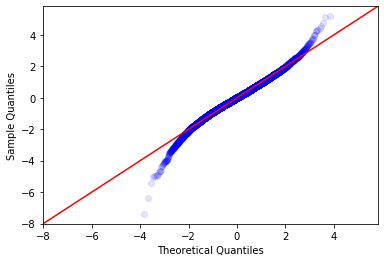

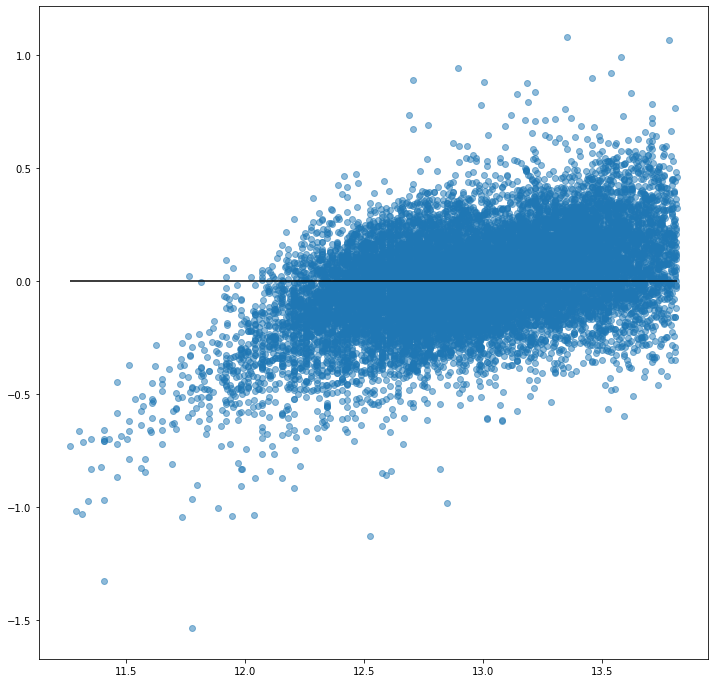

In [334]:
# Model so far:
multicollinearity_threshold=0.7
alpha=0.1
to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
          
data_t = data_train.copy()
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_minmax)
data_t = log(data_t, to_log)
data_t = bin_latlong(data_t)
data_t = ohe(data_t, to_ohe)

x_cols = data_t.drop([outcome], axis=1).columns
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
x_cols = simple_selector(data_t, x_cols)

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

410000.0
410000.0
12.92391243868049
12.92391243868049
12.92391243868049
12.92391243868049
84


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


83
82
81
80
79
78
77
76
75
74
73
12.92391243868049
12.92391243868049
12.92391243868049
[(1, 0.36664327006399045), (2, 0.5686740845711282), (3, 0.5946817233889288), (4, 0.6342664994597275), (5, 0.6947773908265691), (6, 0.7429989417336949), (7, 0.7574106878164014), (8, 0.7684298363280283), (9, 0.7735400711171829), (10, 0.7758468118633546), (11, 0.7797434182772403), (12, 0.781990733700322), (13, 0.7829675768739779), (14, 0.7840214512146078), (15, 0.7869206080125843), (16, 0.7905865502804789), (17, 0.79298577437823), (18, 0.7956255934571045), (19, 0.7978423780244955), (20, 0.7997853501671034), (21, 0.8021397003339796), (22, 0.8022797339426231), (23, 0.8030531727366326), (24, 0.803644632044429), (25, 0.8040824931077124), (26, 0.8042781603086542), (27, 0.8044291885123975), (28, 0.8046828563360405), (29, 0.8055190116173037), (30, 0.8058272741736602), (31, 0.8065995366500486), (32, 0.8068437961661705), (33, 0.8079677983227264), (34, 0.8083715032364315), (35, 0.8085446368623102), (36, 0.8089026

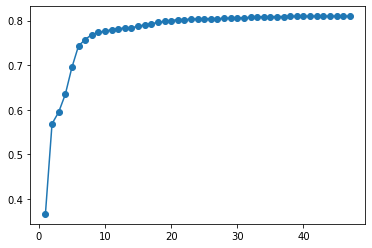

Select number of features
9
12.92391243868049
Number of features: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     6006.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:44:53   Log-Likelihood:                 2489.4
No. Observations:               15824   AIC:                            -4959.
Df Residuals:                   15814   BIC:                            -4882.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       12.9606      0.002   7883.246      0.000      12.957      12.964
condition__sqft_basement         0.0631      0.002     31.946      0.000       0.059       0.067
sqft_above                       0.1499      0.003     53.966      0.000       0.144       0.155
lat                              0.2043      0.002    110.727      0.000       0.201       0.208
Campground__Gated_w_Building     0.1909      0.002     80.857      0.000       0.186       0.195
grade                            0.0975      0.002     39.876      0.000       0.093       0.102
Gate_wo_Building_pow_2          -0.0395      0.002    -18.918      0.000      -0.044      -0.035
Access_Point__Campground        -0.1392      0.002    -63.768      0.000      -0.143      -0.135
condition__sqft_living15         0.0755      0.002     34.705      0.000       0.071       0.080
Access_Point__view               0.0500      0.002     29.160      0.000       0.047       0.053
==============================================================================
Omnibus:                      583.633   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1611.644
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       4.543   Cond. No.                         3.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

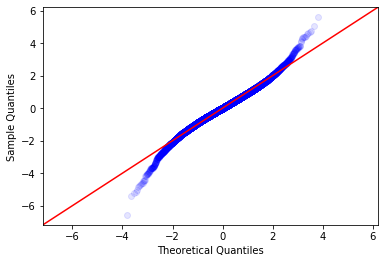

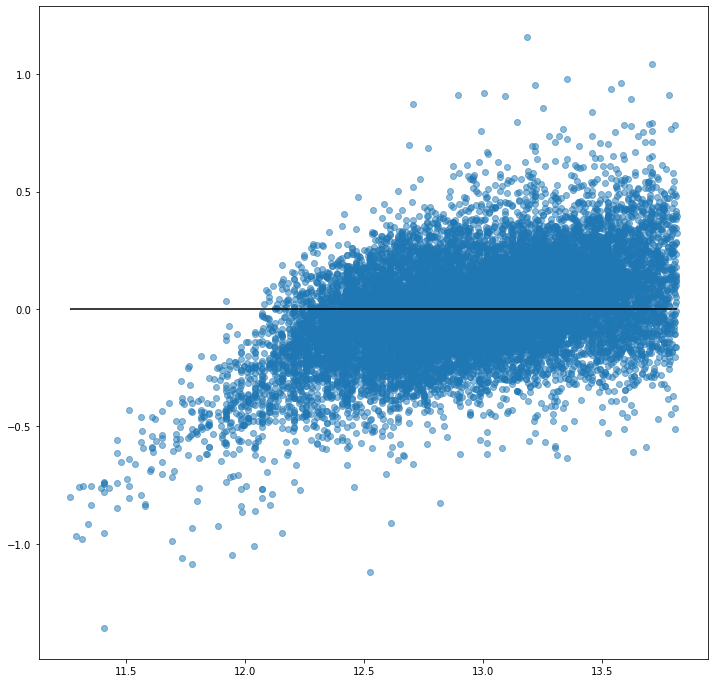

In [335]:
multicollinearity_threshold=0.7
alpha=0.1
data_t = data_train.copy()

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
to_poly = data_t.drop(['lat', 'long', 'lat_long', 'waterfront', 'zipcode', 
                       'price'], axis=1).columns

print(data_t.price[0])
# data_t = minmax_plus(data_t, to_minmax)
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_poly)
print(data_t.price[0])
data_t = log(data_t, to_log)
print(data_t.price[0])
data_t = polynom(data_t, to_poly)
print(data_t.price[0])
data_t = bin_latlong(data_t)
print(data_t.price[0])
data_t = ohe(data_t, to_ohe)
print(data_t.price[0])
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = simple_selector(data_t, x_cols, alpha=0.15)
x_cols = multicoll_remove(data_t, x_cols, 0.85)
x_cols = simple_selector(data_t, x_cols, alpha=0.1)
x_cols = multicoll_remove(data_t, x_cols, 0.8)
x_cols = stepwise_selector(data_t, x_cols, alpha=0.05)
x_cols = multicoll_remove(data_t, x_cols, 0.7)


print(data_t.price[0])
data_t = data_t[['price'] + x_cols]
print(data_t.price[0])
data_t = norm(data_t, x_cols)
print(data_t.price[0])
x_cols = rfe_selector(data_t, x_cols)


data_t = data_t[['price'] + x_cols]
data_t = data_t.sort_index(axis=1)

print(data_t.price[0])

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [336]:
multicollinearity_threshold=0.7
alpha=0.1
data_tt = data_test.copy()
test = True

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_ohe = ['lat_long']
to_poly = data_tt.drop(['lat', 'long', 'waterfront', 'zipcode', 'price'], axis=1).columns

print(data_tt.price[0])
data_tt = bin_basement(data_tt)
data_tt = minmax_plus(data_tt, to_minmax, test)
print(data_tt.price[0])
data_tt = log(data_tt, to_log)
print(data_tt.price[0])
data_tt = polynom(data_tt, to_poly)
print(data_tt.price[0])
data_tt = bin_latlong(data_tt, test)
print(data_tt.price[0])
data_tt = ohe(data_tt, to_ohe)
print(data_tt.price[0])


#test set may be missing dummies which the model looks for:
missing = list(set(x_cols) -set(list(data_tt.columns)))
for m in missing:
    data_tt[m] = 0
print(data_tt.price[0])
data_tt = data_tt[['price'] + x_cols]
data_tt = data_tt.sort_index(axis=1)
print(data_tt.price[0])
data_tt = norm(data_tt, x_cols, test)
print(data_tt.price[0])

# results 
# metrics(data_tt, results, x_cols)
# results.summary()

462608.0
462608.0
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094


In [340]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(unlog(data_t.price), unlog(y_hat_train))**0.5
y_hat_test = results.predict(data_tt)
rmse_test = MSE(unlog(data_tt.price), unlog(y_hat_test))**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 98503.64777995487 
 Test RMSE: 145347.16392994334


In [345]:
data_train.columns

Index(['Abandoned', 'Access_Point', 'Airport', 'Campground', 'Cemetery',
       'Commercial_Farm', 'Cultural', 'Educational', 'Fire',
       'Gate_wo_Building', 'Gated_w_Building', 'Government', 'Lodging',
       'Police', 'Public_Gathering', 'Seasonal_Home', 'Utility', 'bathroomsx4',
       'bedrooms', 'condition', 'date', 'floorsx2', 'grade', 'lat', 'long',
       'price', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15',
       'sqft_lot', 'sqft_lot15', 'view', 'waterfront', 'yr_built',
       'yr_renovated', 'zipcode'],
      dtype='object')

410000.0
410000.0
12.92391243868049
12.92391243868049
81


C:\Users\Maltanno\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


80
79
78
77
76
75
74
73
72
71
70
69
12.92391243868049
12.92391243868049
12.92391243868049
[(1, 0.2569593447972993), (2, 0.36838095589019426), (3, 0.5444739413210771), (4, 0.5447101576390273), (5, 0.5878954833579583), (6, 0.6278038767486371), (7, 0.667976436129383), (8, 0.6937160662696755), (9, 0.7015804148614089), (10, 0.7179741187659758), (11, 0.7293423744908963), (12, 0.7409472669356738), (13, 0.7444046144017488), (14, 0.7472358138662052), (15, 0.749595910067351), (16, 0.7547647452498605), (17, 0.7557492317741797), (18, 0.7572268194860454), (19, 0.7578243045966551), (20, 0.7600540968130227), (21, 0.7613531700434697), (22, 0.7618075881513495), (23, 0.7627143058672122), (24, 0.7632020399000459), (25, 0.7637783753877779), (26, 0.7652099575415161), (27, 0.7653640059015249), (28, 0.7656209089136893), (29, 0.7663371694641888), (30, 0.7666022906970617), (31, 0.7668995763700553), (32, 0.7670969330505076), (33, 0.76732043271017), (34, 0.7675127175423846), (35, 0.7676832468510095), (36, 0.7676

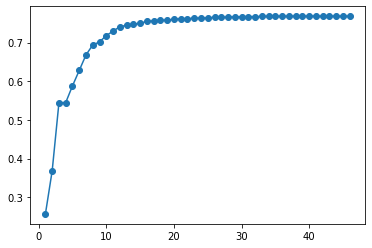

Select number of features
12
12.92391243868049
Number of features: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     3772.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:01:42   Log-Likelihood:                 1427.0
No. Observations:               15824   AIC:                            -2828.
Df Residuals:                   15811   BIC:                            -2728.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        12.9606      0.002   7370.665      0.000      12.957      12.964
Abandoned__Police                -0.0546      0.002    -25.739      0.000      -0.059      -0.050
Gate_wo_Building__sqft_living     0.1381      0.003     53.521      0.000       0.133       0.143
Airport__Cemetery                -0.0733      0.003    -23.799      0.000      -0.079      -0.067
Campground__Gate_wo_Building      0.4026      0.005     85.362      0.000       0.393       0.412
Access_Point__view                0.0492      0.002     26.633      0.000       0.046       0.053
Gated_w_Building__Police          0.0645      0.002     30.062      0.000       0.060       0.069
Airport__Seasonal_Home            0.1722      0.004     44.103      0.000       0.165       0.180
grade                             0.0956      0.002     38.554      0.000       0.091       0.101
Gate_wo_Building_pow_2           -0.3300      0.003   -101.152      0.000      -0.336      -0.324
Access_Point__Campground         -0.0851      0.002    -37.080      0.000      -0.090      -0.081
Airport__Campground              -0.1418      0.005    -28.531      0.000      -0.152      -0.132
condition__sqft_living15          0.0811      0.002     36.044      0.000       0.077       0.085
==============================================================================
Omnibus:                      946.460   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4227.105
Skew:                           0.019   Prob(JB):                         0.00
Kurtosis:                       5.532   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

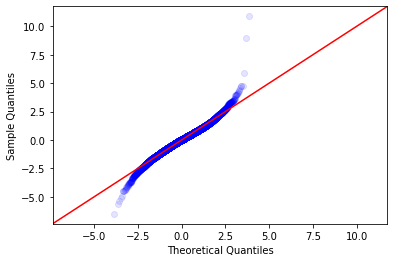

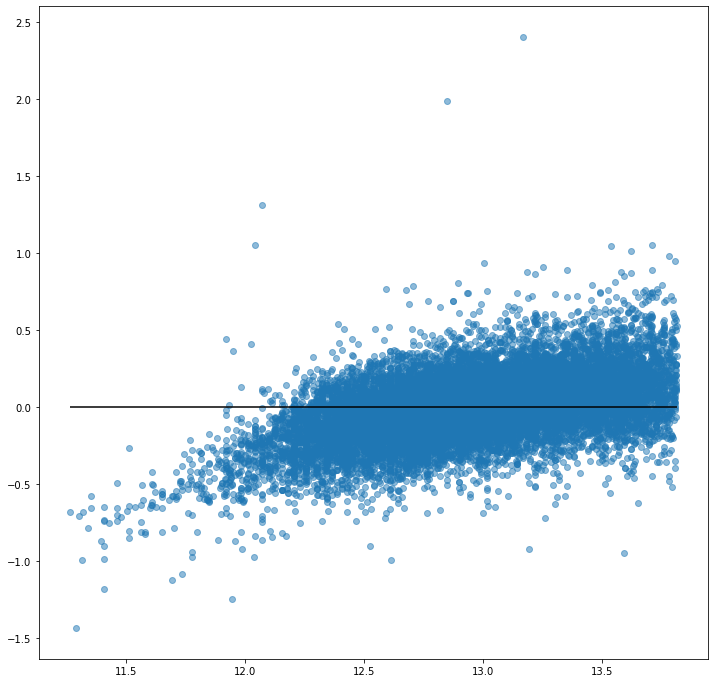

In [350]:
#model with no position:
multicollinearity_threshold=0.7
alpha=0.1
data_t = data_train.copy()

data_t = data_t.drop(['lat', 'long', 'zipcode'], axis=1)

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_poly = data_t.drop(['waterfront', 
                       'price'], axis=1).columns

print(data_t.price[0])
data_t = bin_basement(data_t)
data_t = minmax_plus(data_t, to_poly)
print(data_t.price[0])
data_t = log(data_t, to_log)
print(data_t.price[0])
data_t = polynom(data_t, to_poly)
print(data_t.price[0])
x_cols = data_t.drop([outcome], axis=1).columns


x_cols = simple_selector(data_t, x_cols, alpha=0.15)
x_cols = multicoll_remove(data_t, x_cols, 0.85)
x_cols = simple_selector(data_t, x_cols, alpha=0.1)
x_cols = multicoll_remove(data_t, x_cols, 0.8)
x_cols = stepwise_selector(data_t, x_cols, alpha=0.05)
x_cols = multicoll_remove(data_t, x_cols, 0.7)


print(data_t.price[0])
data_t = data_t[['price'] + x_cols]
print(data_t.price[0])
data_t = norm(data_t, x_cols)
print(data_t.price[0])
x_cols = rfe_selector(data_t, x_cols)


data_t = data_t[['price'] + x_cols]
data_t = data_t.sort_index(axis=1)

print(data_t.price[0])

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [352]:
multicollinearity_threshold=0.7
alpha=0.1
data_tt = data_test.copy()
test = True

data_tt = data_tt.drop(['lat', 'long', 'zipcode'], axis=1)

to_minmax = ['sqft_above', 'sqft_living']
to_log = ['Gate_wo_Building', 'Police', 'Seasonal_Home', 'price', 'sqft_lot']
to_poly = data_tt.drop(['waterfront', 
                       'price'], axis=1).columns

print(data_tt.price[0])
data_tt = bin_basement(data_tt)
data_tt = minmax_plus(data_tt, to_poly)
print(data_tt.price[0])
data_tt = log(data_tt, to_log)
print(data_tt.price[0])
data_tt = polynom(data_tt, to_poly)
print(data_tt.price[0])


#test set may be missing dummies which the model looks for:
missing = list(set(x_cols) -set(list(data_tt.columns)))
for m in missing:
    data_tt[m] = 0
print(data_tt.price[0])
data_tt = data_tt[['price'] + x_cols]
data_tt = data_tt.sort_index(axis=1)
print(data_tt.price[0])
data_tt = norm(data_tt, x_cols, test)
print(data_tt.price[0])


462608.0
462608.0
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094
13.044635322188094


In [353]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(unlog(data_t.price), unlog(y_hat_train))**0.5
y_hat_test = results.predict(data_tt)
rmse_test = MSE(unlog(data_tt.price), unlog(y_hat_test))**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 104126.96359716062 
 Test RMSE: 118296.45508329393


In [357]:
data_r = pd.concat([data_train, unlog(y_hat_train)], axis=1)
data_r.rename(columns={0:'residuals'}, inplace=True)

In [358]:
data_r

Abandoned  Access_Point    Airport  Campground  Cemetery  \
0       5.893764      1.164696   6.643318   19.013668  1.633976   
1       8.714436     10.049091  15.691067    9.335414  7.144825   
2       6.814424     11.080493  16.409209    6.683211  5.200992   
3       6.712401     10.521819   4.774457   12.664551  1.098573   
4       6.478741      3.766792   7.586739   22.936315  0.959414   
...          ...           ...        ...         ...       ...   
15819  11.980122     16.532020   7.072010    7.400391  7.525175   
15820   4.493884      7.691975  10.891062    4.154615  2.713486   
15821   3.313280     10.031022   8.393211    7.426215  7.347886   
15822   7.037417      7.040477  12.628046    5.577830  4.002171   
15823   6.126898     16.475256  15.631370    2.932158  6.537595   

       Commercial_Farm  Cultural  Educational      Fire  Gate_wo_Building  \
0             7.412264  1.580078     0.295245  4.266605         29.834741   
1             4.681551  4.736879     1.554889  2.324892         12.908207   
2             2.370515  2.650616     1.148226  1.624286         11.781791   
3             2.781622  4.873645     0.471625  1.163465         25.783709   
4             4.651500  1.027323     0.870661  1.536092         33.299886   
...                ...       ...          ...       ...               ...   
15819         4.738561  4.037257     0.757450  1.365330         21.414546   
15820         1.306164  5.699637     0.322032  1.652245         40.603552   
15821         4.075260  6.316727     0.808492  4.316122          9.215019   
15822         2.713860  3.746068     0.427735  2.070051         17.228263   
15823         1.980844  2.552152     1.107261  1.977105         10.878255   

       ...  sqft_living  sqft_living15  sqft_lot  sqft_lot15  view  \
0      ...         1660           1570      4000        5500     0   
1      ...         3691           3190     11088       11270     1   
2      ...         2970           2990     11985       12049     0   
3      ...         2100           2730     14027        5999     0   
4      ...         1140           1350      6700        6700     0   
...    ...          ...            ...       ...         ...   ...   
15819  ...         2800           3610      9764        8194     0   
15820  ...         1240           1240      8000        8000     0   
15821  ...         3880           3280      7208        7221     0   
15822  ...         3150           2740      9258       10274     1   
15823  ...         3390           3950     16025       15277     0   

       waterfront  yr_built  yr_renovated  zipcode     residuals  
0               0      1950          1950    98115  4.658238e+05  
1               0      2013          2013    98074  7.406390e+05  
2               0      1995          1995    98074  7.311660e+05  
3               0      1979          1979    98042  4.142127e+05  
4               0      1920          1920    98103  4.284968e+05  
...           ...       ...           ...      ...           ...  
15819           0      2002          2002    98038  4.372155e+05  
15820           0      1954          1954    98198  2.134085e+05  
15821           0      2006          2006    98075  9.133332e+05  
15822           0      1970          1970    98027  6.755352e+05  
15823           0      1987          1987    98077  1.210673e+06  

[15824 rows x 38 columns]

In [364]:
lat = 47.5480
long = -121.9836
base_map = folium.Map([lat,long], zoom_start=7)

x = data_r.lat
y = data_r.long
points = list(zip(x,y))
for p in point:
    lat = p[0]
    long = p[1]
    marker = folium.Marker(location=[lat,long])
    


base_map

In [ ]:
X = data_train.drop(outcome, axis=1)
pca = PCA(n_components = 6, whiten=True)
pca.fit(X)

In [ ]:
pca.components_

In [ ]:
# def transform(data_t, poly=None, test=False):
#     """
#     poly values: 'all', 'list', 'singles', 'all_single'
#     Note: singles/all_single -column names only have first letters
    
#     """

#     poly_order = 2

#     if poly in ['all', 'all_single']:
#         to_poly = data_t.drop(to_ohe + ['price'], axis=1).columns
#         if poly == 'all':
#             poly = 'list'
#         elif poly == 'all_single':
#             poly = 'singles'
#     if poly == 'list':
#         poly=PF(poly_order)
#         data_poly = poly.fit_transform(data_t[to_poly])
#         data_poly = pd.DataFrame(data_poly)
#         data_poly.columns = poly.get_feature_names(data_t[to_poly].columns)
#         data_t = pd.concat([data_t.drop(to_poly, axis=1),
#                             data_poly.drop('1',axis=1)], axis=1)
#     elif poly == 'singles':
#         for feat in to_poly:
#             df = pd.DataFrame(data_t[feat])
#             print(feat)
#             poly=PF(poly_order)
#             data_poly = poly.fit_transform(df)
#             data_poly = pd.DataFrame(data_poly)
#             data_poly.columns = ['drop', feat, feat + '_squared']
#             data_t = pd.concat([data_t.drop(feat, axis=1), 
#                                 data_poly.drop('drop',axis=1)], axis=1)

#     for feat in to_log:
#         data_t[feat] = data_t[feat].map(lambda x: np.log(x) if x!=0 else 0)

        
#     stats = {}
#     if test:
#         with open('norm_stats.pickle', 'rb') as f:
#             stats = pickle.load(f)
#     for feat in to_norm:
#         ft = data_t[feat]
#         if test:
#             mean = stats[feat][0]
#             stdev = stats[feat][1]
#         else:
#             mean = np.mean(ft)
#             stdev = np.sqrt(np.var(ft))
#         data_t[feat] = (ft-mean) / stdev
#         stats[feat] = [mean, stdev]
#     with open('norm_stats.pickle', 'wb') as f:
#         pickle.dump(stats, f)
        
        
#     for feat in to_ohe:
#         dummies = pd.get_dummies(data=data_t[feat], prefix=feat, prefix_sep='_',
#                                 drop_first=True)
#         data_t.drop(feat, axis=1, inplace=True)
#         data_t = pd.concat([data_t, dummies], axis=1)
#     data_t.rename(lambda col: col.replace('.0', '').replace(' ','__')
#                   .replace('^','_pow_'),
#                   axis=1, inplace=True)
    
#     return data_t 



In [40]:
data


Abandoned  Access_Point    Airport  Campground  Cemetery  \
0       2.136789      7.275835   3.673296   11.040112  1.621051   
1       9.426786      4.961174   6.093273   20.270435  1.883651   
2      11.016414      9.238893   2.836639   14.397269  3.456310   
3       8.132931     16.934488   9.420195   15.601558  3.111443   
4       8.815768     11.145737  14.933916    8.819946  7.207596   
...          ...           ...        ...         ...       ...   
21229   6.807081      3.404938   7.878784   22.112902  1.033515   
21230   6.131955     14.821864  10.470231   13.301577  0.705413   
21231   2.302045      7.728936   4.881805   18.707302  3.020970   
21232   7.189766      7.607151  12.135239    3.317056  1.853263   
21233   2.268692      7.736355   4.907806   18.690062  3.049175   

       Commercial_Farm  Cultural  Educational      Fire  Gate_wo_Building  \
0             3.184509  0.460860     0.421127  2.116200         31.195278   
1             8.646702  0.530477     0.347626  1.622418         29.953770   
2             4.486447  2.237051     0.180398  2.463073         23.298991   
3             5.054405  2.741761     0.405319  1.891094         40.006992   
4             4.493620  4.678520     1.132304  1.241106         11.747274   
...                ...       ...          ...       ...               ...   
21229         5.507926  1.555726     0.623718  2.429806         32.407528   
21230         2.619856  0.721808     0.564096  2.642585         38.283140   
21231         1.166611  1.232718     0.354845  0.523932         30.873183   
21232         0.777705  2.299058     1.794700  1.076554         18.246999   
21233         1.180370  1.260705     0.354800  0.556755         30.879959   

       ...  sqft_basement  sqft_living  sqft_living15  sqft_lot  sqft_lot15  \
0      ...              0         1180           1340      5650        5650   
1      ...            400         2570           1690      7242        7639   
2      ...              0          770           2720     10000        8062   
3      ...            910         1960           1360      5000        5000   
4      ...              0         1680           1800      8080        7503   
...    ...            ...          ...            ...       ...         ...   
21229  ...              0         1530           1530      1131        1509   
21230  ...              0         2310           1830      5813        7200   
21231  ...              0         1020           1020      1350        2007   
21232  ...              0         1600           1410      2388        1287   
21233  ...              0         1020           1020      1076        1357   

       view  waterfront  yr_built  yr_renovated  zipcode  
0         0           0      1955          1955    98178  
1         0           0      1951          1991    98125  
2         0           0      1933          1933    98028  
3         0           0      1965          1965    98136  
4         0           0      1987          1987    98074  
...     ...         ...       ...           ...      ...  
21229     0           0      2009          2009    98103  
21230     0           0      2014          2014    98146  
21231     0           0      2009          2009    98144  
21232     0           0      2004          2004    98027  
21233     0           0      2008          2008    98144  

[19780 rows x 37 columns]

410000.0
410000.0
410000.0
410000.0
Number of features: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     2159.
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:35:57   Log-Likelihood:            -2.0398e+05
No. Observations:               15824   AIC:                         4.080e+05
Df Residuals:                   15800   BIC:                         4.082e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -2.704e+07   5.02e+05    -53.878      0.000    -2.8e+07   -2.61e+07
Police            2524.2879    232.586     10.853      0.000    2068.393    2980.183
sqft_lot             0.2247      0.040      5.608      0.000       0.146       0.303
Government       -5464.3243   1058.127     -5.164      0.000   -7538.374   -3390.275
sqft_living        109.1950      1.782     61.288      0.000     105.703     112.687
Lodging           7577.3409    609.513     12.432      0.000    6382.625    8772.057
Access_Point     -6991.1627    267.437    -26.141      0.000   -7515.370   -6466.955
Gated_w_Building  1.016e+04    203.376     49.959      0.000    9761.766    1.06e+04
lat               5.945e+05   1.01e+04     58.741      0.000    5.75e+05    6.14e+05
condition         2.342e+04   1277.733     18.332      0.000    2.09e+04    2.59e+04
Fire               773.1249    677.150      1.142      0.254    -554.166    2100.416
Campground        2952.7816    223.302     13.223      0.000    2515.084    3390.479
Cultural          8925.9536    629.344     14.183      0.000    7692.368    1.02e+04
date                83.0040      6.790     12.225      0.000      69.696      96.312
Commercial_Farm  -3720.3808    451.033     -8.249      0.000   -4604.458   -2836.304
sqft_lot15           0.0051      0.108      0.047      0.962      -0.206       0.216
view              2.522e+04   1350.403     18.674      0.000    2.26e+04    2.79e+04
Gate_wo_Building -2426.1095    143.193    -16.943      0.000   -2706.784   -2145.435
grade             6.414e+04   1210.085     53.006      0.000    6.18e+04    6.65e+04
Abandoned        -4315.8297    336.571    -12.823      0.000   -4975.546   -3656.113
Educational      -1359.4539    689.642     -1.971      0.049   -2711.230      -7.677
bedrooms         -6321.9969   1122.613     -5.632      0.000   -8522.447   -4121.547
yr_built          -792.2714     36.775    -21.544      0.000    -864.355    -720.188
waterfront        1.895e+05   1.59e+04     11.947      0.000    1.58e+05    2.21e+05
==============================================================================
Omnibus:                     1024.997   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1982.297
Skew:                           0.465   Prob(JB):                         0.00
Kurtosis:                       4.464   Cond. No.                     1.84e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

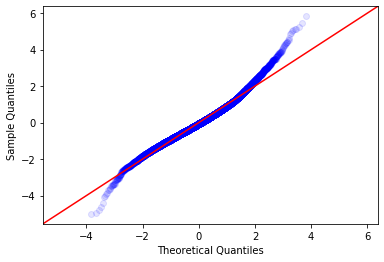

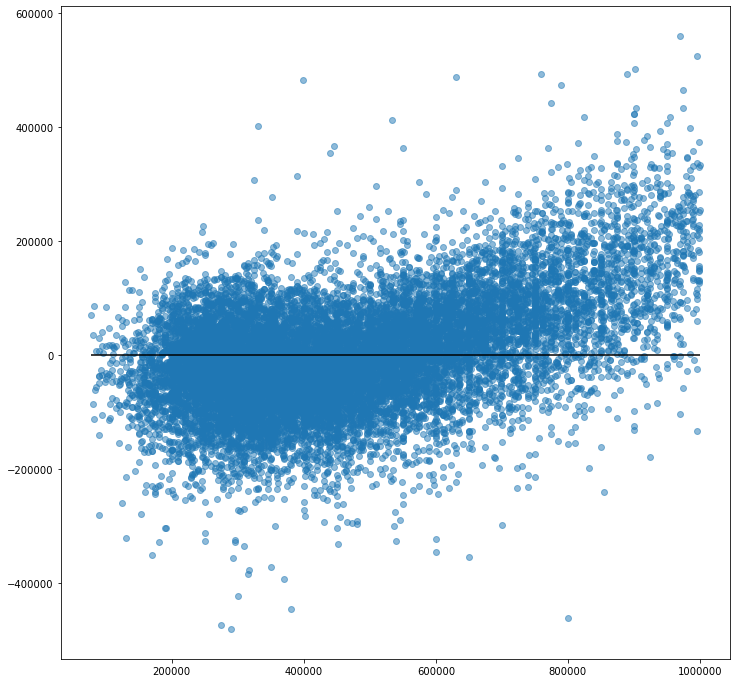

In [271]:
multicollinearity_threshold=0.7
alpha=0.05
outcome = 'price'

data_t = data_train.copy()
print(data_t.price[0])

x_cols = data_t.drop([outcome], axis=1).columns
print(data_t.price[0])

x_cols = simple_selector(data_t, x_cols, alpha=alpha)
x_cols = multicoll_remove(data_t, x_cols, multicollinearity_threshold)
print(data_t.price[0])

data_t = data_t[['price'] + x_cols]
print(data_t.price[0])

results = model(data_t, x_cols)
metrics(data_t, results, x_cols)
results.summary()

In [272]:
data_tt = data_test.copy()
test = True
print(data_tt.price[0])

# #test set may be missing dummies which the model looks for:
# missing = list(set(x_cols) -set(list(data_tt.columns)))
# for m in missing:
#     data_tt[m] = 0



data_tt = data_tt[['price'] + x_cols]
print(data_tt.price[0])


462608.0
462608.0


In [279]:
y_hat_train = results.predict(data_t)
rmse_train = MSE(data_t.price, y_hat_train)**0.5
y_hat_test = results.predict(data_tt)
rmse_test = MSE(data_tt.price, y_hat_test)**0.5
print(f'Train RMSE: {rmse_train} \n Test RMSE: {rmse_test}')

Train RMSE: 95967.33954821377 
 Test RMSE: 97006.7346766306


In [278]:
y_hat_train.describe()
MSE(data_t.price, y_hat_train)**0.5

95967.33954821377

In [270]:
y_hat_test.describe()

count    3.956000e+03
mean     4.690282e+05
std      1.707726e+05
min     -3.590379e+04
25%      3.424844e+05
50%      4.708736e+05
75%      5.802954e+05
max      1.456968e+06
dtype: float64